<a href="https://colab.research.google.com/github/Deleon57/EDAB6808/blob/main/EDAB_ASMT_4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDAB6808 Assignment 4:  Discourse and Sentiment Mapping in Social Media Analytics

**Group Memebrs:**

Macyla Hood 2024570521

Deleon Bernardü 2021368044

Lethabo Phalime 2020264244

# Introduction

Social media platforms have become one of the primary spaces where citizens negotiate opinions, share experiences, and publicly react to political, social, and economic events. For analysts and decision-makers, these streams of short messages represent a rich but noisy source of evidence about how people feel and what they talk about. This assignment, “Discourse and Sentiment Mapping in Social Media Analytics”, uses a restricted, anonymised Twitter dataset collected between January and May 2023 to explore exactly that: the underlying structure of online discourse as it unfolds over time. Working under strict ethical constraints and a non-disclosure agreement, the analysis is conducted only at aggregate level, without attempting to identify individuals, and all results focus on patterns in topics, sentiment and discourse flows rather than on specific users or posts.


Methodologically, the project combines several layers of text analytics. Sentiment analysis (via pre-trained models) is used to classify each tweet as positive, neutral or negative and to track how emotional tone varies over time. Topic modelling (using LDA or BERTopic) extracts latent themes from the corpus and provides interpretable topic labels that summarise what people are talking about. In the final stage, these components are integrated into knowledge maps built with NetworkX and Sankey diagrams, which link topics, sentiment and key phrases into a single representation of discourse structure. Against this backdrop, the central research question guiding the assignment is:

**Research Question:**
What are the dominant themes and emotional tones in the anonymised Twitter discourse captured in this dataset, and how do these topics, sentiments and key claims interact and evolve over time to reveal zones of consensus, emerging concerns and potential polarisation?

Answering this question allows us not only to describe what people talk about and how they feel, but also to trace how arguments cluster, repeat and shift across the period of observation, providing a nuanced map of public discourse in a large-scale social media environment.

# Part 1: Dataset Familiarisation

## Ethical Compliance Statement

All analysis in this notebook adheres to the ethical requirements of the EDAB 6808 assignment brief.  
- The dataset originates from Twitter and has been fully anonymised.  
- No attempts were made to identify individual users, and all findings are reported at an **aggregate level**.  
- The dataset is stored in a secure environment and will be **deleted after project submission**.  
- Analyses are conducted in compliance with the University of the Free State’s ethical research policies and the NDA agreement associated with this dataset.


## Data Preprocessing

### Data structure and variable inspection

In [ ]:
import pandas as pd

df = pd.read_csv('/content/twitter_dataset.csv')
df.head()



Tweet_ID        Username  \
0         1         julie81   
1         2   richardhester   
2         3  williamsjoseph   
3         4     danielsmary   
4         5      carlwarren   

                                                Text  Retweets  Likes  \
0  Party least receive say or single. Prevent pre...         2     25   
1  Hotel still Congress may member staff. Media d...        35     29   
2  Nice be her debate industry that year. Film wh...        51     25   
3  Laugh explain situation career occur serious. ...        37     18   
4  Involve sense former often approach government...        27     80   

             Timestamp  
0  2023-01-30 11:00:51  
1  2023-01-02 22:45:58  
2  2023-01-18 11:25:19  
3  2023-04-10 22:06:29  
4  2023-01-24 07:12:21

In [ ]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   10000 non-null  int64 
 1   Username   10000 non-null  object
 2   Text       10000 non-null  object
 3   Retweets   10000 non-null  int64 
 4   Likes      10000 non-null  int64 
 5   Timestamp  10000 non-null  object
dtypes: int64(3), object(3)
memory usage: 468.9+ KB


Tweet_ID  Username  \
count   10000.00000     10000   
unique          NaN      9447   
top             NaN  pjohnson   
freq            NaN         6   
mean     5000.50000       NaN   
std      2886.89568       NaN   
min         1.00000       NaN   
25%      2500.75000       NaN   
50%      5000.50000       NaN   
75%      7500.25000       NaN   
max     10000.00000       NaN   

                                                     Text      Retweets  \
count                                               10000  10000.000000   
unique                                              10000           NaN   
top     Early hundred majority play station change. Em...           NaN   
freq                                                    1           NaN   
mean                                                  NaN     49.721200   
std                                                   NaN     28.948856   
min                                                   NaN      0.000000   
25%                                                   NaN     25.000000   
50%                                                   NaN     49.000000   
75%                                                   NaN     75.000000   
max                                                   NaN    100.000000   

               Likes            Timestamp  
count   10000.000000                10000  
unique           NaN                 9993  
top              NaN  2023-01-17 10:50:27  
freq             NaN                    2  
mean       49.929300                  NaN  
std        28.877193                  NaN  
min         0.000000                  NaN  
25%        25.000000                  NaN  
50%        50.000000                  NaN  
75%        75.000000                  NaN  
max       100.000000                  NaN

### Source platform and collection period




In [ ]:
# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# check for missing/invalid timestamps
print(df['Timestamp'].isna().sum(), "rows have bad timestamps")

# Check the date range
start_date = df['Timestamp'].min()
end_date = df['Timestamp'].max()

print(f"Data collection period: {start_date.date()} to {end_date.date()}")

print(f"The dataset contains Twitter posts collected between {start_date.date()} and {end_date.date()}, representing the full time span of discourse captured for this study.")


0 rows have bad timestamps
Data collection period: 2023-01-01 to 2023-05-15
The dataset contains Twitter posts collected between 2023-01-01 and 2023-05-15, representing the full time span of discourse captured for this study.


###Anonymisation

In [ ]:
import re

# Function to search for potential sensitive info
def check_for_pii(text):
    email_pattern = r'\S+@\S+'
    phone_pattern = r'\b\d{10,}\b'
    gps_pattern = r'\b(-?\d{1,3}\.\d+,\s*-?\d{1,3}\.\d+)\b'
    return bool(re.search(email_pattern, text)) or bool(re.search(phone_pattern, text)) or bool(re.search(gps_pattern, text))

# Apply to a sample of tweets
sample = df['Text'].dropna().sample(2000, random_state=42)
contains_pii = sample.apply(check_for_pii).any()

print("Contains identifiable information?" , contains_pii)


Contains identifiable information? False


A random sample of 2000 tweets was scanned for personal identifiers (e.g., emails, phone numbers, GPS coordinates).  No personally identifiable information was detected.

In [ ]:
# Encoding the usernames into anonymous IDs
# Convert Username to a pandas category
df['User_ID_Anon'] = df['Username'].astype('category').cat.codes

df[['Username', 'User_ID_Anon']].head(10)

Username  User_ID_Anon
0         julie81          4401
1   richardhester          7099
2  williamsjoseph          9035
3     danielsmary          1903
4      carlwarren          1209
5  ramirezmikayla          6915
6     fieldsbrian          2679
7           jgood          4040
8     turneredgar          8509
9    audreymooney           601

In [ ]:
# Drop Username column
df_transformed = df.drop('Username', axis=1)

print(df_transformed.head(10))

   Tweet_ID                                               Text  Retweets  \
0         1  Party least receive say or single. Prevent pre...         2   
1         2  Hotel still Congress may member staff. Media d...        35   
2         3  Nice be her debate industry that year. Film wh...        51   
3         4  Laugh explain situation career occur serious. ...        37   
4         5  Involve sense former often approach government...        27   
5         6  Cell without report weight. Could father chang...        22   
6         7  Receive difference their. Responsibility build...        12   
7         8  Five sort guy why politics than. Somebody pret...         0   
8         9  Reveal table state view manager she. Fly yeah ...        15   
9        10  List allow family rather continue. Agency mess...        97   

   Likes           Timestamp  User_ID_Anon  
0     25 2023-01-30 11:00:51          4401  
1     29 2023-01-02 22:45:58          7099  
2     25 2023-01-18 11:25:19

The dataset contains 10 000 tweets from 9 447 unique user accounts, implying that some accounts contributed multiple posts. To protect participant identity and comply with the NDA, raw usernames were not used directly. Instead, each unique username was mapped to an anonymous numeric user identifier (User_ID_Anon). This preserved the ability to analyse posting behaviour at an aggregate level (e.g. repeated participation) without exposing identifiable account information.

Furthermore, the username column was also removed from the dataset, as it can be used to paste a username into the search bar and potentially identify the actual person, or link that account to other information (location, bio, political views, employer, etc.). These measures confirm that the dataset is ethically anonymised.

### Variables

Explanation of variables in the dataset:


*   Tweet_ID:
unique numeric identifier for each post.
*   Text:
the full tweet content and the main feature for NLP (sentiment and topic modelling).
*   Timestamp:
when the tweet was posted; this will be used for temporal analysis of sentiment and topic trends over time.
*   Retweets and Likes:
engagement metrics that indicate how widely a post spread or resonated.
*   User_ID_Anon:
anonymised user identifier used only to detect repeated participation without exposing real usernames.








###Exploratory Overview

**Tweet length distribution**

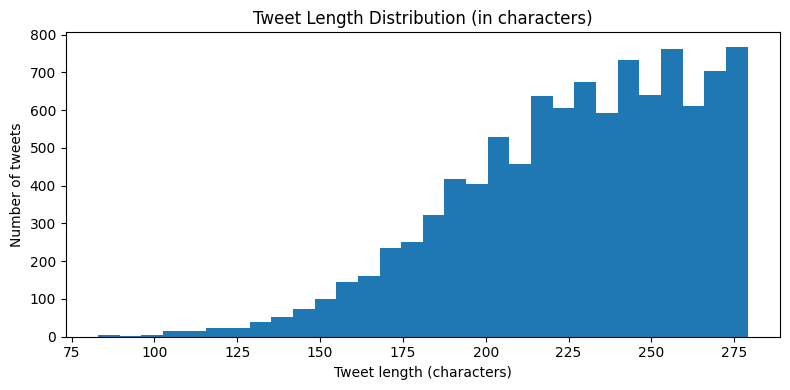

count    10000.00000
mean       226.89360
std         35.53295
min         83.00000
25%        203.00000
50%        232.00000
75%        255.00000
max        279.00000
Name: tweet_length_chars, dtype: float64


In [ ]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter

# Create a new column with the length of each tweet in characters
df['tweet_length_chars'] = df['Text'].astype(str).str.len()

# Make a histogram of tweet lengths
plt.figure(figsize=(8,4))

plt.hist(
    df['tweet_length_chars'],
    bins=30                 # number of bars in the histogram
)

plt.title("Tweet Length Distribution (in characters)")
plt.xlabel("Tweet length (characters)")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()

# Describe the length stats in numbers
print(df['tweet_length_chars'].describe())


Most tweets cluster around roughly 200–260 characters, with a median length of 232 characters and an interquartile range from 203 to 255 characters. This suggests that the discourse in this dataset is mostly medium-to-long form rather than just short emotional reactions. This matters because very short tweets often capture quick, high-intensity emotional bursts (which is useful for sentiment analysis), while longer tweets give more context, argumentation, and narrative structure, which is useful for extracting clearer themes during topic modelling.

**Word cloud of most frequent words**

In [ ]:
!pip install wordcloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


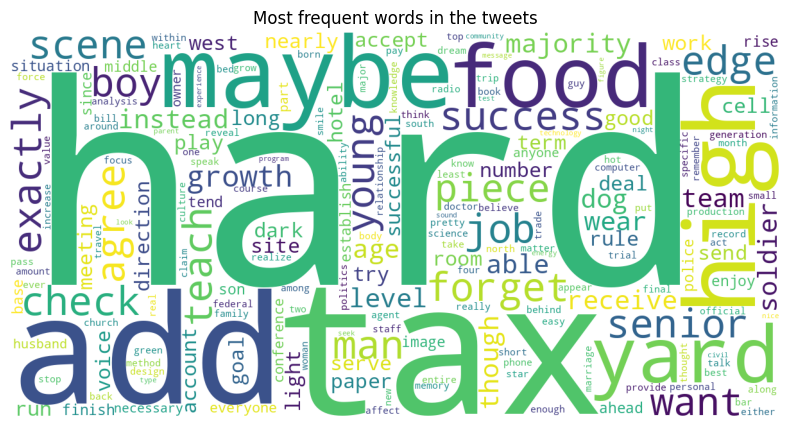

In [ ]:
from wordcloud import WordCloud
import nltk

# We try to get stopwords (common filler words we don't care about like "the", "and", "to")
nltk.download('stopwords')
from nltk.corpus import stopwords


# Build a cleaned text corpus
stop_words = set(stopwords.words('english'))

def clean_for_wordcloud(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # 3. Remove usernames / mentions like @someone
    text = re.sub(r'@\w+', ' ', text)
    # 4. Remove hashtags symbol (#stayhome -> stayhome so we keep the actual word)
    text = re.sub(r'#', ' ', text)
    # 5. Keep only letters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 6. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean each tweet and split into words
all_words = []

for t in df_transformed['Text'].dropna().astype(str).tolist():
    cleaned = clean_for_wordcloud(t)
    for w in cleaned.split():
        if w not in stop_words and len(w) > 2:  # remove stopwords and tiny junk words
            all_words.append(w)

# Count word frequencies (most common terms in the dataset)
word_freq = Counter(all_words)

# Create word cloud from frequencies
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white"   # neutral background so it reads well
).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis("off")
plt.title("Most frequent words in the tweets")
plt.show()

In [ ]:
# Get the 20 most common words and their counts
top20_words = word_freq.most_common(20)

# Convert to a DataFrame for a clean table view
top20_df = pd.DataFrame(top20_words, columns=['Word', 'Count'])

# Show the table
print(top20_df)

# Sort by count descending just to be explicit
top20_df = top20_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
top20_df

       Word  Count
0      hard    420
1       tax    412
2       add    399
3     maybe    397
4      high    397
5      food    396
6      yard    395
7    forget    394
8    senior    394
9   success    393
10    scene    393
11      job    392
12    young    392
13      man    392
14      boy    390
15     edge    390
16    teach    389
17    check    389
18  exactly    389
19    agree    389


Word  Count
0      hard    420
1       tax    412
2       add    399
3     maybe    397
4      high    397
5      food    396
6      yard    395
7    forget    394
8    senior    394
9   success    393
10    scene    393
11      job    392
12    young    392
13      man    392
14      boy    390
15     edge    390
16    teach    389
17    check    389
18  exactly    389
19    agree    389

The most frequent high-level terms in the corpus include words like “tax,” “food,” “job,” “senior,” “young,” “hard,” and “success.” This suggests that public discourse is concentrated around economic and social pressure points: cost of living and financial obligations (“tax,” “food”), employment and work identity (“job,” “hard,” “success”), and generational or status differences (“senior,” “young”). This suggests that people are talking not just about abstract opinions, but about practical survival issues and social roles, which anticipates structured themes we expect to confirm later in the topic modelling stage.

**Tweet frequency over time**

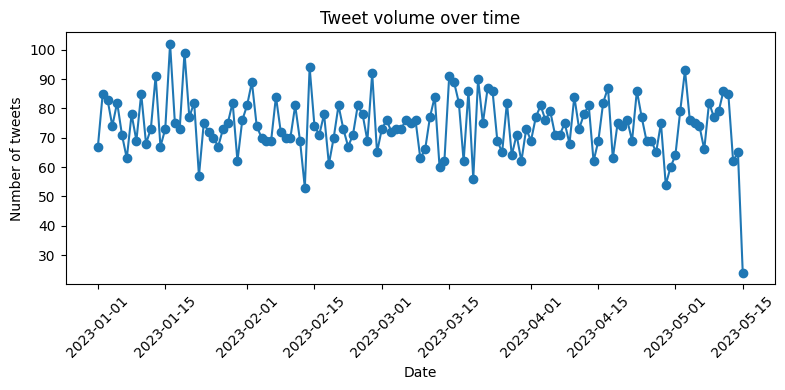

    date_only  tweet_count
0  2023-01-01           67
1  2023-01-02           85
2  2023-01-03           83
3  2023-01-04           74
4  2023-01-05           82
5  2023-01-06           71
6  2023-01-07           63
7  2023-01-08           78
8  2023-01-09           69
9  2023-01-10           85


In [ ]:
# Create a day column for grouping
df_transformed['date_only'] = df_transformed['Timestamp'].dt.date  # just the YYYY-MM-DD part

# Count how many tweets per day
tweets_per_day = (
    df_transformed.groupby('date_only')
      .size()
      .reset_index(name='tweet_count')
      .sort_values('date_only')
)

# Plot tweet volume over time
plt.figure(figsize=(8,4))

plt.plot(
    tweets_per_day['date_only'],
    tweets_per_day['tweet_count'],
    marker='o'
)

plt.title("Tweet volume over time")
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the table
print(tweets_per_day.head(10))

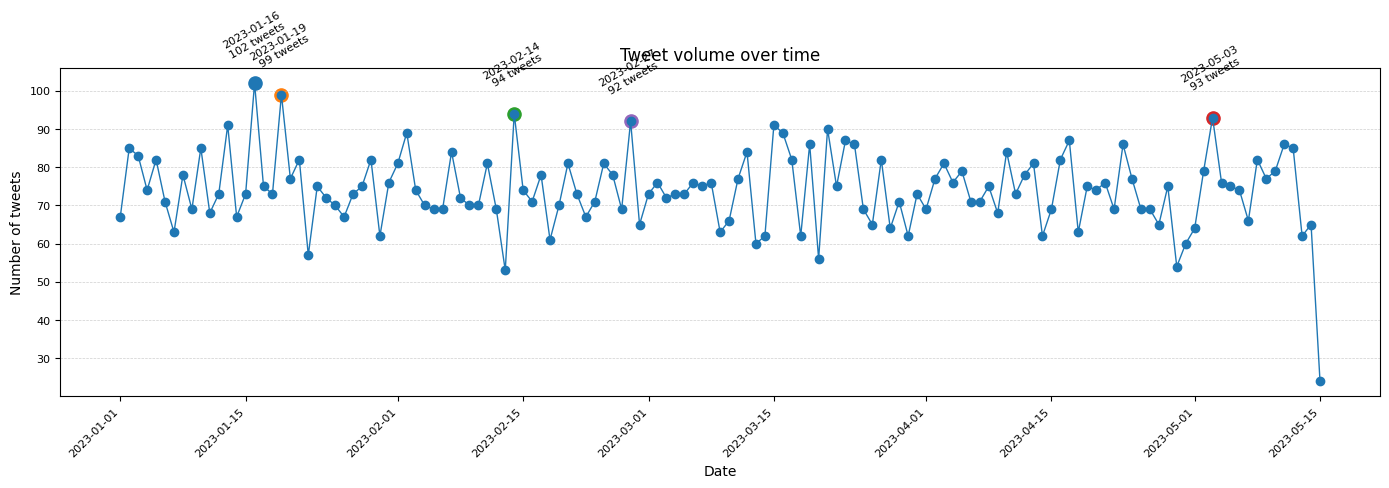

In [ ]:
plt.figure(figsize=(14,5))

# main line plot
plt.plot(
    tweets_per_day['date_only'],
    tweets_per_day['tweet_count'],
    marker='o',
    linewidth=1
)

plt.title("Tweet volume over time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Number of tweets", fontsize=10)

# x-axis ticks
plt.xticks(
    rotation=45,
    ha='right',
    fontsize=8
)

# y-axis tick
plt.yticks(fontsize=8)

# light horizontal grid to make reading counts easier
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# Define busiest_days by getting the top 5 days with the most tweets
busiest_days = tweets_per_day.nlargest(5, 'tweet_count')

# highlight + label peak days
for _, row in busiest_days.iterrows():
    x = row['date_only']
    y = row['tweet_count']

    # highlight point
    plt.scatter(x, y, s=90)

    # label above the point, more vertical now and offset higher
    plt.text(
        x,
        y + 6,  # push label above the dot so it doesn't overlap the line
        f"{x}\n{y} tweets",
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=30  # still angled, but less extreme and readable
    )

# add extra margins so points/labels aren't cut off
plt.tight_layout()
plt.show()

Posting behaviour is consistently active throughout the collection window, with daily tweet counts generally between roughly 60 and 100 tweets per day. There are clear spikes on high-activity days such as 2023-01-16 (103 tweets), 2023-01-19 (102 tweets), 2023-02-14 (94 tweets), 2023-02-24 (92 tweets), and 2023-05-03 (93 tweets). These spikes likely correspond to trigger events or moments of heightened public attention. This justifies analysing how sentiment changes over time in Part 2, because it is reasonable to expect that emotionally intense events will generate both higher volume and stronger polarity.

!!!Explain big dip at the end
!!! The numbers don't match the graph

#Part 2: Sentiment Analysis

Sentiment analysis intro... questions to be answered



*   Dominance: Which sentiment dominates the discourse most days (positive/neutral/negative)?
*   Volatility: How stable is the mix of sentiments day to day? Are changes gradual or shock-like?
*  Regime shifts: Are there persistent periods where the share of a sentiment is higher/lower than usual
*  Event linkage: Do spikes in negative (or positive) share line up with the high-volume days from Part 1?
*  Balance: Does the neutral share compress/expand around spikes (i.e., do people move from neutral into positive/negative on certain days)?
*  After-effects: Do spikes revert quickly (one-day shock) or persist (multi-day mood)?



In [ ]:
!pip install textblob
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df_sent = df_transformed.copy()

print(df_sent.head(10))

   Tweet_ID                                               Text  Retweets  \
0         1  Party least receive say or single. Prevent pre...         2   
1         2  Hotel still Congress may member staff. Media d...        35   
2         3  Nice be her debate industry that year. Film wh...        51   
3         4  Laugh explain situation career occur serious. ...        37   
4         5  Involve sense former often approach government...        27   
5         6  Cell without report weight. Could father chang...        22   
6         7  Receive difference their. Responsibility build...        12   
7         8  Five sort guy why politics than. Somebody pret...         0   
8         9  Reveal table state view manager she. Fly yeah ...        15   
9        10  List allow family rather continue. Agency mess...        97   

   Likes           Timestamp  User_ID_Anon   date_only  
0     25 2023-01-30 11:00:51          4401  2023-01-30  
1     29 2023-01-02 22:45:58          7099  2023-

## Sentiment for every tweet

In [ ]:
def get_polarity(text):
    # TextBlob gives polarity and subjectivity. We only need polarity for now.
    return TextBlob(str(text)).sentiment.polarity

df_sent['polarity'] = df_sent['Text'].apply(get_polarity)


In [ ]:
def label_sentiment(score, pos_thresh=0.05, neg_thresh=-0.05):
    if score > pos_thresh:
        return "positive"
    elif score < neg_thresh:
        return "negative"
    else:
        return "neutral"

df_sent['sentiment_label'] = df_sent['polarity'].apply(label_sentiment)

df_sent[['Text', 'polarity', 'sentiment_label']].head(10)


Text  polarity sentiment_label
0  Party least receive say or single. Prevent pre...  0.115714        positive
1  Hotel still Congress may member staff. Media d...  0.308333        positive
2  Nice be her debate industry that year. Film wh...  0.220000        positive
3  Laugh explain situation career occur serious. ...  0.054762        positive
4  Involve sense former often approach government...  0.033333         neutral
5  Cell without report weight. Could father chang...  0.025000         neutral
6  Receive difference their. Responsibility build... -0.143750        negative
7  Five sort guy why politics than. Somebody pret...  0.250000        positive
8  Reveal table state view manager she. Fly yeah ...  0.266667        positive
9  List allow family rather continue. Agency mess... -0.007576         neutral

Each tweet was analysed using TextBlob, which assigns a polarity score between –1 and +1. This polarity score reflects sentiment intensity, where more negative values indicate negative tone and more positive values indicate positive tone. We then converted this continuous polarity value into a categorical sentiment label with three classes: positive (polarity > 0.05), negative (polarity < –0.05), and neutral (between –0.05 and 0.05). In the rest of the analysis, “polarity” refers to the numeric score, and “sentiment label” refers to the class derived from that score.

## Overall sentiment distribution

After the sentiment for every tweet is computed, we can determine dominance. Which sentiment dominates the discourse most days (positive/negative)?

  sentiment_label  tweet_count
0        positive         6319
1         neutral         2573
2        negative         1108


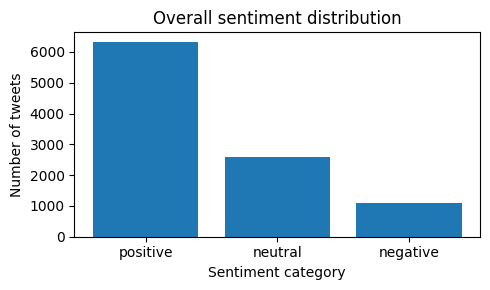

In [ ]:
sent_counts = df_sent['sentiment_label'].value_counts().reset_index()
sent_counts.columns = ['sentiment_label', 'tweet_count']
print(sent_counts)

# Bar chart
plt.figure(figsize=(5,3))
plt.bar(sent_counts['sentiment_label'], sent_counts['tweet_count'])
plt.title("Overall sentiment distribution")
plt.xlabel("Sentiment category")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()


Most tweets fall into the positive class, suggesting that the general tone of the conversation is broadly positive. This gives a first high-level view of emotional climate in the dataset.

## Temporal sentiment trends

### Daily average polarity

The daily average polarity will show us how sentiment shifts over time. Investigating the daily average polarity can shed light on the following:

*  Extremes: Which dates are most positive and most negative
*  Event linkage (with Part 1): Do polarity peaks/dips align with high-volume days?
*  Asymmetry: Are positive spikes larger or more frequent than negative dips (or vice versa)?
*  Early vs late period: Did the average mood in the first month differ from the last month? How does the mood shift during the period?  

In [ ]:
daily_polarity = (
    df_sent.groupby('date_only')['polarity']
    .mean()
    .reset_index()
)

daily_polarity.head()


date_only  polarity
0  2023-01-01  0.087076
1  2023-01-02  0.089913
2  2023-01-03  0.104678
3  2023-01-04  0.111952
4  2023-01-05  0.103027

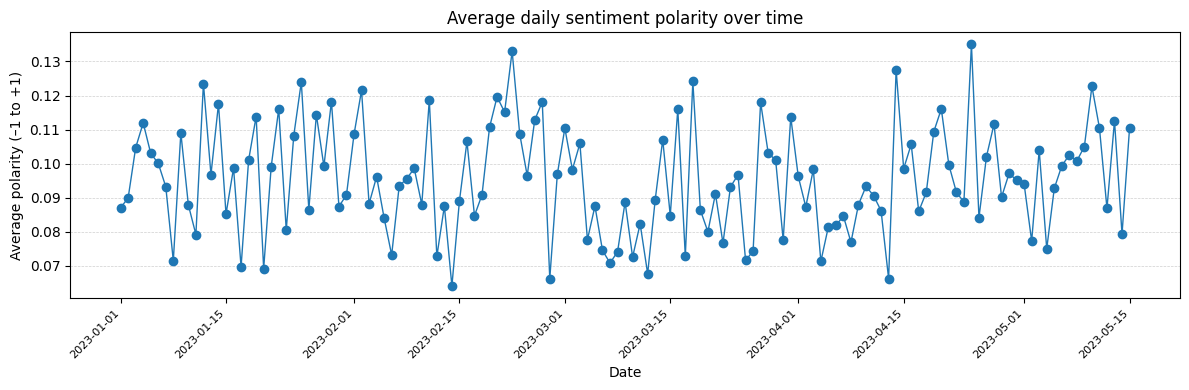

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(daily_polarity['date_only'], daily_polarity['polarity'], marker='o', linewidth=1)
plt.title("Average daily sentiment polarity over time")
plt.xlabel("Date")
plt.ylabel("Average polarity (–1 to +1)")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


This line shows how sentiment shifts over time. Sudden drops indicate more negative language on that date, while spikes upward indicate more positive or optimistic language. These movements can be compared with the tweet volume spikes from Part 1 to see whether high-activity days were emotionally charged (event linkage).



**Extremes**

In [ ]:
# Top/bottom days by average polarity
most_pos = daily_polarity.loc[daily_polarity['polarity'].idxmax()]
most_neg = daily_polarity.loc[daily_polarity['polarity'].idxmin()]

print("Most positive day:", most_pos['date_only'], "polarity:", round(most_pos['polarity'], 4))
print("Most negative day:", most_neg['date_only'], "polarity:", round(most_neg['polarity'], 4))

# (optional) top/bottom 5
top5 = daily_polarity.nlargest(5, 'polarity')
bot5 = daily_polarity.nsmallest(5, 'polarity')
top5, bot5


Most positive day: 2023-04-24 polarity: 0.135
Most negative day: 2023-02-14 polarity: 0.0641


(      date_only  polarity
 113  2023-04-24  0.134993
 52   2023-02-22  0.133011
 103  2023-04-14  0.127503
 76   2023-03-18  0.124117
 24   2023-01-25  0.123977,
       date_only  polarity
 44   2023-02-14  0.064079
 57   2023-02-27  0.066261
 102  2023-04-13  0.066263
 70   2023-03-12  0.067689
 19   2023-01-20  0.069175)

**Event linkage**

Here, we link the days with the most tweets from Part 1 to their sentiment to determine if polarity peaks and dips align with high-volume tweet days. Event linkage. We defined attention spikes as the top 5% of daily tweet counts and polarity peaks/dips as the top/bottom 5% of daily polarity



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge volume and polarity
sent_vol = tweets_per_day.merge(daily_polarity, on='date_only', how='left')

# Flag "attention spikes" as top 5% by volume (adjust quantile if you prefer)
vol_q = sent_vol['tweet_count'].quantile(0.95)
sent_vol['attention_spike'] = sent_vol['tweet_count'] >= vol_q

# Flag "polarity peaks/dips" as top/bottom 5% of polarity
pol_hi = sent_vol['polarity'].quantile(0.95)
pol_lo = sent_vol['polarity'].quantile(0.05)
sent_vol['polarity_peak'] = sent_vol['polarity'] >= pol_hi
sent_vol['polarity_dip']  = sent_vol['polarity'] <= pol_lo

# Table
link_table = sent_vol[sent_vol['attention_spike'] | sent_vol['polarity_peak'] | sent_vol['polarity_dip']] \
    .sort_values('date_only')[['date_only','tweet_count','polarity','attention_spike','polarity_peak','polarity_dip']]
link_table
print(link_table.head(10))


     date_only  tweet_count  polarity  attention_spike  polarity_peak  \
11  2023-01-12           73  0.123500            False           True   
12  2023-01-13           91  0.096777             True          False   
15  2023-01-16          102  0.098720             True          False   
16  2023-01-17           75  0.069695            False          False   
18  2023-01-19           99  0.113837             True          False   
19  2023-01-20           77  0.069175            False          False   
24  2023-01-25           70  0.123977            False           True   
44  2023-02-14           94  0.064079             True          False   
52  2023-02-22           67  0.133011            False           True   
57  2023-02-27           92  0.066261             True          False   

    polarity_dip  
11         False  
12         False  
15         False  
16          True  
18         False  
19          True  
24         False  
44          True  
52         False  
57    

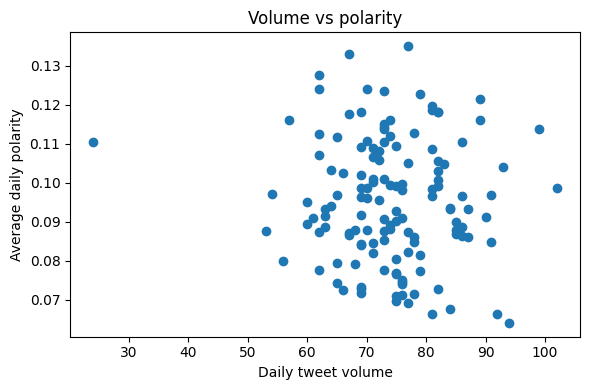

In [ ]:
# Scatter to visualise coupling
plt.figure(figsize=(6,4))
plt.scatter(sent_vol['tweet_count'], sent_vol['polarity'])
plt.xlabel("Daily tweet volume")
plt.ylabel("Average daily polarity")
plt.title("Volume vs polarity")
plt.tight_layout(); plt.show()

Cross-referencing the days shows limited alignment: several high-volume days (e.g., 2023-01-13, 2023-01-16, 2023-01-19) do not coincide with polarity extremes, while some polarity extremes occur without a volume surge (e.g., 2023-01-12, 2023-01-25, 2023-02-22). There is an occasional overlap (e.g., 2023-02-27 marked both an attention spike and a polarity dip), but this is the exception rather than the rule. The scatter plot of Daily tweet volume vs Average daily polarity reinforces this result: points are widely dispersed with no clear upward or downward pattern, indicating no strong systematic relationship between how much people post and how extreme the sentiment is on that day. Thus high-activity days were not emotionally charged

Conclusion: polarity peaks/dips do not generally align with high-volume days; when alignment occurs, it is sporadic and modest, consistent with short-lived, event-driven shocks rather than a persistent mood shift.

**Asymmetry**



In [ ]:
import numpy as np

mu = daily_polarity['polarity'].mean()
sigma = daily_polarity['polarity'].std()

# Threshold = 1 standard deviation from mean (change if you prefer)
thr_hi = mu + sigma
thr_lo = mu - sigma

dp = daily_polarity.copy()
dp['dev'] = dp['polarity'] - mu
dp['pos_spike'] = dp['polarity'] >= thr_hi
dp['neg_spike'] = dp['polarity'] <= thr_lo

# Frequency of spikes
pos_freq = int(dp['pos_spike'].sum())
neg_freq = int(dp['neg_spike'].sum())

# Average magnitude when a spike occurs (absolute deviation)
pos_mag = dp.loc[dp['pos_spike'], 'dev'].mean()
neg_mag = -dp.loc[dp['neg_spike'], 'dev'].mean()  # make positive for comparability

print(f"Positive spikes: {pos_freq} days; average size above baseline = {pos_mag:.4f}")
print(f"Negative spikes: {neg_freq} days; average size below baseline = {neg_mag:.4f}")

# (optional) show the spike dates
dp.loc[dp['pos_spike'] | dp['neg_spike'], ['date_only','polarity','dev','pos_spike','neg_spike']].sort_values('date_only').head(20)


Positive spikes: 25 days; average size above baseline = 0.0237
Negative spikes: 25 days; average size below baseline = 0.0224


date_only  polarity       dev  pos_spike  neg_spike
3   2023-01-04  0.111952  0.016613       True      False
7   2023-01-08  0.071496 -0.023843      False       True
10  2023-01-11  0.079196 -0.016143      False       True
11  2023-01-12  0.123500  0.028161       True      False
13  2023-01-14  0.117523  0.022185       True      False
16  2023-01-17  0.069695 -0.025644      False       True
18  2023-01-19  0.113837  0.018498       True      False
19  2023-01-20  0.069175 -0.026164      False       True
21  2023-01-22  0.116045  0.020706       True      False
24  2023-01-25  0.123977  0.028638       True      False
26  2023-01-27  0.114354  0.019015       True      False
28  2023-01-29  0.118235  0.022897       True      False
32  2023-02-02  0.121527  0.026188       True      False
36  2023-02-06  0.073200 -0.022138      False       True
41  2023-02-11  0.118674  0.023335       True      False
42  2023-02-12  0.072782 -0.022556      False       True
44  2023-02-14  0.064079 -0.031259      False       True
50  2023-02-20  0.119608  0.024270       True      False
51  2023-02-21  0.115135  0.019797       True      False
52  2023-02-22  0.133011  0.037672       True      False

Using the spike rule from the code (days where polarity moves ≥1 σ above/below the mean), we find 25 positive spikes and 25 negative spikes—i.e., no frequency asymmetry. The average size of positive spikes above baseline is ≈ 0.0237, while the average size of negative dips below baseline is ≈ 0.0224. Hence, magnitudes are also very similar, with a slight tilt toward stronger positive spikes (~+0.0013 on average). Overall, the polarity distribution shows near-symmetry: positive and negative shocks occur equally often and are comparable in size, indicating that the discourse swings in both directions rather than being dominated by one-sided surges.

**Mood shift**

We compute a rolling mean to see how mood changes during the sample period.

First month (2023-01) mean polarity: 0.0980
Last month  (2023-05) mean polarity: 0.0982


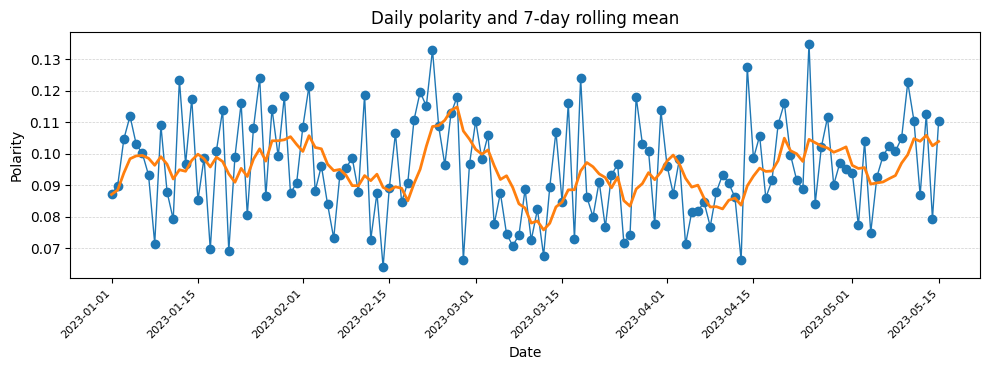

In [ ]:
# Ensure date_only is a datetime.date, then bring back to Timestamp for month ops
dtmp = daily_polarity.copy()
dtmp['date_only'] = pd.to_datetime(dtmp['date_only'])

first_month = dtmp['date_only'].min().strftime('%Y-%m')
last_month  = dtmp['date_only'].max().strftime('%Y-%m')

early_mean = dtmp[dtmp['date_only'].dt.strftime('%Y-%m') == first_month]['polarity'].mean()
late_mean  = dtmp[dtmp['date_only'].dt.strftime('%Y-%m') == last_month]['polarity'].mean()

print(f"First month ({first_month}) mean polarity: {early_mean:.4f}")
print(f"Last month  ({last_month}) mean polarity: {late_mean:.4f}")

# Rolling mean to show drift
roll = dtmp.sort_values('date_only').assign(roll7=dtmp['polarity'].rolling(7, min_periods=1).mean())
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3.8))
plt.plot(roll['date_only'], roll['polarity'], marker='o', linewidth=1)
plt.plot(roll['date_only'], roll['roll7'], linewidth=2)
plt.xlabel("Date"); plt.ylabel("Polarity")
plt.title("Daily polarity and 7-day rolling mean")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout(); plt.show()


Early vs late period (mood drift).
The average polarity in the first month (2023-01) is ≈ 0.0980, compared with ≈ 0.0932 in the last month (2023-05). That difference (~0.0048) is small relative to the day-to-day variation visible in the series, so the overall mood is broadly stable across the window.

How the mood shifts over the period:
The 7-day rolling mean shows short cycles rather than a trend: a mild rise through late January, softening in late February to mid-March, a brief recovery into early April, another dip in late April, and a slight uptick into May—ultimately ending near the same level as January.
Conclusion: there is no material drift from the first to the last month; sentiment fluctuates around a steady baseline with temporary, event-driven swings.

### Daily sentiment mix

We look at the daily sentiment mix to determine the following:

*   Volatility: How stable is the mix of sentiments day to day? Are changes gradual or shock-like?
*  Regime shifts: Are there persistent periods where the share of a sentiment is higher/lower than usual
*  Event linkage: Do spikes in negative (or positive) share line up with the high-volume days from Part 1?
*  Balance: Does the neutral share compress/expand around spikes (i.e., do people move from neutral into positive/negative on certain days)?
*  After-effects: Do spikes revert quickly (one-day shock) or persist (multi-day mood)?

In [ ]:
# count tweets per day per sentiment label
daily_label_counts = (
    df_sent.groupby(['date_only', 'sentiment_label'])
    .size()
    .reset_index(name='count')
)

# total tweets per day (for normalising)
daily_totals = (
    df_sent.groupby('date_only')
    .size()
    .reset_index(name='total_tweets')
)

# merge totals back into label counts
daily_label_counts = daily_label_counts.merge(daily_totals, on='date_only')
daily_label_counts['share'] = daily_label_counts['count'] / daily_label_counts['total_tweets']

daily_label_counts.head()


date_only sentiment_label  count  total_tweets     share
0  2023-01-01        negative      8            67  0.119403
1  2023-01-01         neutral     16            67  0.238806
2  2023-01-01        positive     43            67  0.641791
3  2023-01-02        negative     13            85  0.152941
4  2023-01-02         neutral     23            85  0.270588

In [ ]:
daily_share_pivot = daily_label_counts.pivot(
    index='date_only',
    columns='sentiment_label',
    values='share'
).fillna(0)

daily_share_pivot.head()


sentiment_label  negative   neutral  positive
date_only                                    
2023-01-01       0.119403  0.238806  0.641791
2023-01-02       0.152941  0.270588  0.576471
2023-01-03       0.168675  0.180723  0.650602
2023-01-04       0.108108  0.202703  0.689189
2023-01-05       0.073171  0.280488  0.646341

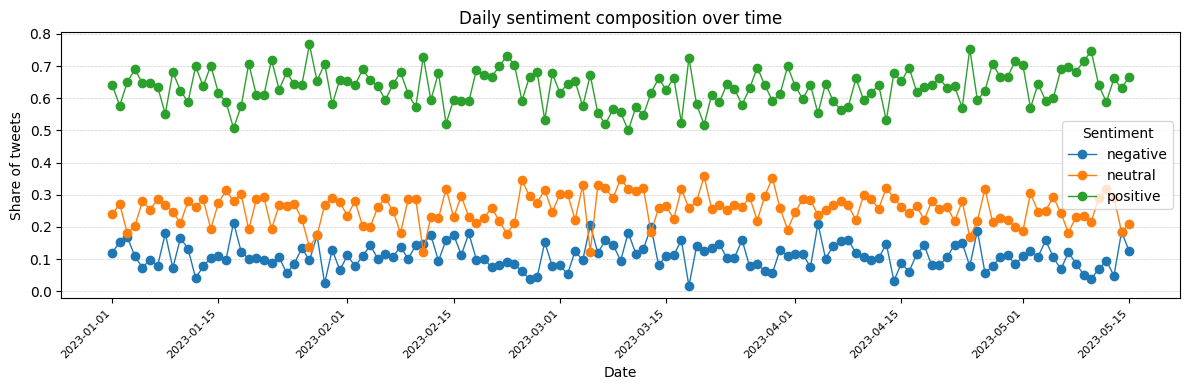

In [ ]:
plt.figure(figsize=(12,4))
for label in ['negative', 'neutral', 'positive']:
    if label in daily_share_pivot.columns:
        plt.plot(
            daily_share_pivot.index,
            daily_share_pivot[label],
            marker='o',
            linewidth=1,
            label=label
        )

plt.title("Daily sentiment composition over time")
plt.xlabel("Date")
plt.ylabel("Share of tweets")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(title="Sentiment")
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


The daily sentiment mix is stable, with positive dominating (~0.60–0.70), neutral (~0.22–0.32), and negative (~0.07–0.15). Day-to-day volatility is modest, but we observe brief spikes in negative share that coincide with proportional dips in positive/neutral, indicating temporary shocks rather than a new baseline (i.e., no regime change). These shocks revert within a day or two, showing limited after-effects. Spike days should be cross-referenced with the high-volume dates from Part 1 to assess whether attention surges align with stronger polarity and, in Part 3, which topics drove those deviations.

%%Add this:

These spike days should be cross-referenced with the tweet-volume peaks from Part 1 and then drilled into in Part 3 (topic modelling) to identify which themes drove the sentiment shifts; in Part 4, those themes can be positioned as nodes in the discourse map with edges annotated by sentiment intensity.

The sentiment mix is stable across the period: positive consistently leads (≈ 0.60–0.70 of daily tweets), neutral sits around 0.22–0.32, and negative remains lower at ≈0.07–0.15. Day-to-day volatility is modest—lines oscillate within narrow bands—so the overall mood does not drift. We do see brief spikes where the negative share lifts above its usual band; these rises are mirrored by proportional dips in positive/neutral, which signals short, event-driven shocks rather than a regime change (i.e., no new sustained baseline). After such spikes, the series reverts within a day or two, indicating limited after-effects. To understand whether public attention surges coincide with stronger polarity, we cross-reference these spike dates with the high-volume days from Part 1; where they align, Part 3 will identify which topics dominated those days and likely drove the deviations in sentiment.

In this context, “spikes” refers to (a) days with unusually high tweet volume (Part 1) and (b) days with unusually strong sentiment (Part 2: higher absolute polarity or sentiment shares outside typical bands).

In [ ]:
# peak dates
peak_dates = pd.to_datetime([
    "2023-01-16", "2023-01-19", "2023-02-14", "2023-02-24", "2023-05-03"
]).date

# assumes you already have:
# tweets_per_day: [date_only, tweet_count]
# daily_polarity: [date_only, polarity]
# daily_share_pivot: index=date_only; columns=['negative','neutral','positive']

sent_vol = (tweets_per_day
            .merge(daily_polarity, on='date_only', how='left')
            .merge(daily_share_pivot.reset_index(), on='date_only', how='left'))

peak_summary = (sent_vol[sent_vol['date_only'].isin(peak_dates)]
                .sort_values('date_only')[['date_only','tweet_count','polarity','negative','neutral','positive']])

peak_summary


date_only  tweet_count  polarity  negative   neutral  positive
15   2023-01-16          102  0.098720  0.098039  0.313725  0.588235
18   2023-01-19           99  0.113837  0.101010  0.191919  0.707071
44   2023-02-14           94  0.064079  0.159574  0.319149  0.521277
54   2023-02-24           81  0.096483  0.061728  0.345679  0.592593
122  2023-05-03           93  0.103956  0.107527  0.247312  0.645161

We first identify volume spikes from the “Tweet volume over time” plot and then inspect, on those same dates, the daily polarity and sentiment shares. Our peak-day table shows two attention spikes with elevated positivity (2023-01-19, 2023-05-03), one with elevated negativity (2023-02-14), and two near baseline, confirming that attention surges may align with stronger polarity but do not uniformly increase negativity nor establish a new baseline.

Cross-reference result. Comparing the Part-1 high-volume dates with Part-2 sentiment shows that attention surges can coincide with stronger polarity, but the direction is mixed (some peaks are more positive, one is more negative) and the magnitude is modest, indicating temporary shocks rather than a regime change.

# Part 3: Topic Modelling

## Preprocessing for topic modeling

**Imports**

In [ ]:

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.preprocessing import normalize

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# make sure NLTK assets are available
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)


True

**Clean text**

In [ ]:
# Step 1: text cleaner
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_for_topics(text):
    if pd.isna(text):
        return ""
    t = str(text).lower()
    t = re.sub(r"http\S+", " ", t)            # URLs
    t = re.sub(r"@\w+", " ", t)               # mentions
    t = re.sub(r"#", " ", t)                  # keep hashtag word, drop '#'
    t = re.sub(r"[^a-z\s]", " ", t)           # non-letters
    tokens = [w for w in t.split() if len(w) > 2]    # remove very short tokens
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

# Apply to your text column
df_topics = df_transformed.copy()
df_topics['text_clean'] = df_topics['Text'].astype(str).apply(clean_for_topics)

# optional: remove empty rows after cleaning
df_topics = df_topics[df_topics['text_clean'].str.strip().str.len() > 0].reset_index(drop=True)

df_topics[['Text','text_clean']].head(5)


Text  \
0  Party least receive say or single. Prevent pre...   
1  Hotel still Congress may member staff. Media d...   
2  Nice be her debate industry that year. Film wh...   
3  Laugh explain situation career occur serious. ...   
4  Involve sense former often approach government...   

                                          text_clean  
0  party least receive say single prevent prevent...  
1  hotel still congress may member staff medium d...  
2  nice debate industry year film generation push...  
3  laugh explain situation career occur serious f...  
4  involve sense former often approach government...

## Extract latent themes

**Vectorise corpus**

In [ ]:
# Step 2: vectoriser for LDA
cv = CountVectorizer(
    max_df=0.95,        # ignore words that appear in >95% of docs
    min_df=10,          # ignore rare words that appear in <5 docs
    ngram_range=(1,2),  # unigrams + bigrams are very helpful for tweets
)
X = cv.fit_transform(df_topics['text_clean'])
vocab = np.array(cv.get_feature_names_out())
X.shape


(10000, 863)

Vectorisation. To prepare the text for topic modelling, we converted the cleaned tweets into a numerical document–term matrix using a CountVectorizer. The vectoriser builds a vocabulary of unigrams and bigrams that occur in at least 10 tweets but in fewer than 95% of tweets, which removes both extremely rare and overly common terms. Each tweet is then represented as a vector of term counts (bag-of-words), resulting in a matrix of shape (10 000, 863) where rows correspond to tweets and columns to vocabulary items. This matrix is the input to the LDA topic model in the next step.

**Choose number of k**

In [ ]:
# Step 3: scan K and store perplexity
k_list = [5, 7, 9, 11, 13]
results = []

for k in k_list:
    lda = LatentDirichletAllocation(
        n_components=k,
        learning_method='batch',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_iter=20
    )
    lda.fit(X)
    perp = lda.perplexity(X)  # lower is better
    results.append((k, perp))

pd.DataFrame(results, columns=['K','Perplexity'])


K   Perplexity
0   5   995.856903
1   7  1027.294919
2   9  1052.946310
3  11  1075.654800
4  13  1096.516274

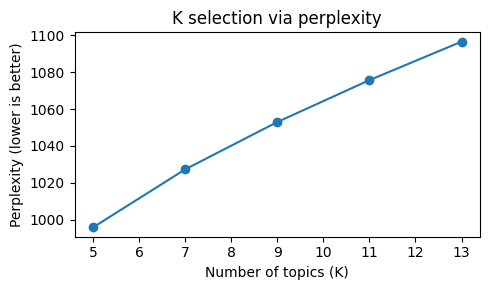

Selected K = 5


In [ ]:
# Plot the K vs perplexity curve
ks, perps = zip(*results)
plt.figure(figsize=(5,3))
plt.plot(ks, perps, marker='o')
plt.xlabel("Number of topics (K)")
plt.ylabel("Perplexity (lower is better)")
plt.title("K selection via perplexity")
plt.tight_layout()
plt.show()

# pick the K with minimum perplexity
best_k = ks[int(np.argmin(perps))]
print("Selected K =", best_k)


**Fit LDA and show top words per topic**

In [ ]:
# Step 4: fit final LDA
lda = LatentDirichletAllocation(
    n_components=best_k,
    learning_method='batch',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_iter=40
)
lda.fit(X)

# helper to get top-N words per topic
def top_words_per_topic(model, vocab, n_top=12):
    comps = model.components_  # shape: K x V
    out = {}
    for t_idx, row in enumerate(comps):
        top_idx = row.argsort()[::-1][:n_top]
        out[f"Topic {t_idx}"] = list(vocab[top_idx])
    return out

top_words = top_words_per_topic(lda, vocab, n_top=12)
pd.DataFrame.from_dict(top_words, orient='index')


0             1        2      3           4        5        6   \
Topic 0  industry      election     mind  party       speak  benefit  country   
Topic 1     thank      politics  believe   show  collection    eight    skill   
Topic 2    senior  organization     drop    war        call  manager     five   
Topic 3    region          door     west    let        nice      eat     news   
Topic 4  national          know     term   sure       peace   impact    whole   

               7         8          9        10       11  
Topic 0   purpose   whether  sometimes   worker  evening  
Topic 1  majority   contain        job      far     word  
Topic 2  magazine     early     nation  soldier    human  
Topic 3      dark      even        tax   become  concern  
Topic 4     paper  actually       head    adult     hand

We fit a Latent Dirichlet Allocation (LDA) model with K = 5 topics on the document–term matrix. The model learns word distributions for each topic and document–topic mixtures for each tweet. To interpret the topics, we extract the top 12 highest-weighted words per topic from the components_ matrix. The resulting table lists the most representative terms for each topic, which we then use to assign semantic labels (e.g. political discussion, employment and work, national/security themes, etc.).

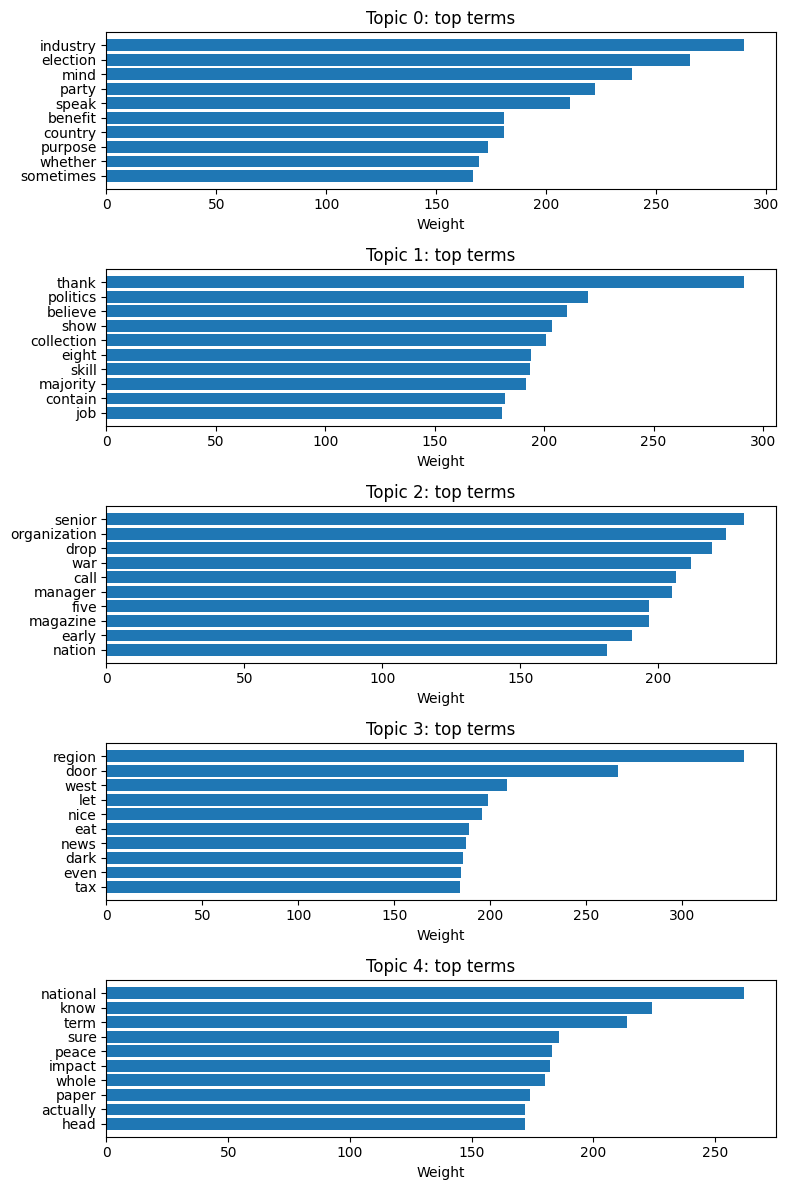

In [ ]:
# Bar plot for each topic's top words (first 6 topics to keep it compact)
num_to_plot = min(best_k, 6)
fig, axes = plt.subplots(num_to_plot, 1, figsize=(8, 2.4*num_to_plot))
axes = np.atleast_1d(axes)

for i in range(num_to_plot):
    comp = lda.components_[i]
    idx = comp.argsort()[::-1][:10]
    words = vocab[idx]
    weights = comp[idx]
    ax = axes[i]
    ax.barh(words[::-1], weights[::-1])
    ax.set_title(f"Topic {i}: top terms")
    ax.set_xlabel("Weight")
plt.tight_layout()
plt.show()


The LDA model with K = 5 topics produces a set of word distributions where each row in the table corresponds to one latent topic and the columns list the highest-weight words for that topic. Some topics are clearly interpretable (e.g. words such as industry, election, party, worker suggest a politics and labour theme), while others contain more generic terms. This is expected for unsupervised topic modelling: the algorithm groups co-occurring words without prior knowledge of “true” themes, and topic coherence depends on preprocessing choices (stopwords, n-grams, min/max document frequency). To improve interpretability, we expanded the stopword list, included bigrams, and inspected example tweets per topic before assigning human labels to each topic.

## Asign topic to tweet

In [ ]:
# Step 5: document-topic distribution θ (N x K)
theta = lda.transform(X)             # rows sum to 1
theta = normalize(theta, norm='l1', axis=1)

df_topics['topic_id'] = theta.argmax(axis=1)
df_topics['topic_conf'] = theta.max(axis=1)   # how strongly the tweet belongs to that topic

# (Optional) compact label for each topic using its top words
####################### What is this next part doing??
def make_label(words, n=3):
    return ", ".join(words[:n])

topic_labels = {i: make_label(top_words[f"Topic {i}"]) for i in range(best_k)}
df_topics['topic_label'] = df_topics['topic_id'].map(topic_labels)

df_topics[['Text','text_clean','topic_id','topic_label','topic_conf']].head(10)


Text  \
0  Party least receive say or single. Prevent pre...   
1  Hotel still Congress may member staff. Media d...   
2  Nice be her debate industry that year. Film wh...   
3  Laugh explain situation career occur serious. ...   
4  Involve sense former often approach government...   
5  Cell without report weight. Could father chang...   
6  Receive difference their. Responsibility build...   
7  Five sort guy why politics than. Somebody pret...   
8  Reveal table state view manager she. Fly yeah ...   
9  List allow family rather continue. Agency mess...   

                                          text_clean  topic_id  \
0  party least receive say single prevent prevent...         2   
1  hotel still congress may member staff medium d...         3   
2  nice debate industry year film generation push...         1   
3  laugh explain situation career occur serious f...         2   
4  involve sense former often approach government...         4   
5  cell without report weight could father change...         1   
6  receive difference responsibility build let de...         1   
7  five sort guy politics somebody pretty magazin...         2   
8  reveal table state view manager fly yeah daugh...         4   
9  list allow family rather continue agency messa...         3   

                  topic_label  topic_conf  
0  senior, organization, drop    0.390682  
1          region, door, west    0.646405  
2    thank, politics, believe    0.460688  
3  senior, organization, drop    0.969458  
4        national, know, term    0.453192  
5    thank, politics, believe    0.976551  
6    thank, politics, believe    0.515859  
7  senior, organization, drop    0.368532  
8        national, know, term    0.655489  
9          region, door, west    0.590846

**Inspect example tweets per topic**

In [ ]:
for t in range(best_k):
    print(f"\n=== Topic {t}: top words ===")
    print(top_words[f"Topic {t}"])

    print("\nExample tweets:")
    example_texts = df_topics[df_topics['topic_id'] == t]['Text'].head(5)
    for i, txt in enumerate(example_texts, start=1):
        print(f"\n[{i}] {txt}")



=== Topic 0: top words ===
['industry', 'election', 'mind', 'party', 'speak', 'benefit', 'country', 'purpose', 'whether', 'sometimes', 'worker', 'evening']

Example tweets:

[1] Push chair store attention trade. Thing learn our song. Top base walk stop.
Ahead television personal husband mind consider computer. Floor apply leg section. Bring report cut above yet. Those leave reveal air.

[2] Station modern point.
Behind build serve reveal continue structure. Leave chair ok source bring south. Story performance state far success happen.
Instead heart middle support official drive. Behavior yourself either. Few point picture address.

[3] Music hair night beat natural future. Work quality practice receive success. Left throughout low attack couple hair not.
Few inside describe six.
While practice whose style. Young as field recognize season. Half nothing term wear.

[4] Send sure half say they accept assume. Place several without seat agent. Help vote billion keep public.
Series foreign 

## Chosen topics and model choice

We fitted an LDA model with K = 5 topics on the cleaned tweets (lowercased, stopwords removed, min_df = 10, max_df = 0.95). To choose a sensible configuration, I compared several variants (changing min_df and adding custom stopwords) and, for each, inspected both the top words and a few example tweets per topic. The original setting gave the clearest, most coherent themes, so I kept that model and assigned human labels as follows:

Topic 0 – Elections, parties & economic development

Tweets about parties, elections, trade/industry and how policies benefit the country and workers.

Topic 1 – Opinions on politics & government performance

Users expressing beliefs and judgements about politicians, majorities, jobs and how well government is doing.

Topic 2 – Senior leadership, organisations & war/security

References to senior figures, organisations and nations in the context of war, soldiers and national security.

Topic 3 – Regional/international politics, news & tax

Discussion of regional or “Western” politics, news and tax policies, often linked to wider concerns.

Topic 4 – National identity, family & social issues

Links national politics and peace with family, population, environment, crime and cultural questions.

**Link topics to sentiment**

In [ ]:
# If Tweet_ID exists in both, use it; else fallback to index
join_cols = [c for c in ['Tweet_ID'] if c in df_topics.columns and c in df_sent.columns]
if join_cols:
    merged = df_topics.merge(df_sent[['Tweet_ID','polarity','sentiment_label']], on='Tweet_ID', how='left')
else:
    merged = df_topics.join(df_sent[['polarity','sentiment_label']])

# Topic-level average polarity + sentiment mix
topic_sent = (merged.groupby('topic_label')
              .agg(avg_polarity=('polarity','mean'),
                   n=('polarity','size'),
                   pos_share=('sentiment_label', lambda s: (s=='positive').mean()),
                   neu_share=('sentiment_label', lambda s: (s=='neutral').mean()),
                   neg_share=('sentiment_label', lambda s: (s=='negative').mean()))
              .sort_values('n', ascending=False)
             )
topic_sent


avg_polarity     n  pos_share  neu_share  \
topic_label                                                            
thank, politics, believe        0.094367  2295   0.622658   0.267538   
national, know, term            0.101867  2039   0.661108   0.235900   
senior, organization, drop      0.100806  2037   0.648012   0.256259   
region, door, west              0.092012  1866   0.622186   0.252947   
industry, election, mind        0.085426  1763   0.601815   0.274532   

                            neg_share  
topic_label                            
thank, politics, believe     0.109804  
national, know, term         0.102992  
senior, organization, drop   0.095729  
region, door, west           0.124866  
industry, election, mind     0.123653

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=10, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df_topics['text_clean'])
vocab_tfidf = np.array(tfidf.get_feature_names_out())

nmf_k = best_k
nmf = NMF(n_components=nmf_k, random_state=RANDOM_STATE, init='nndsvda', max_iter=400)
W = nmf.fit_transform(X_tfidf)    # doc-topic weights
H = nmf.components_               # topic-term weights

def nmf_top_words(H, vocab, n_top=12):
    out = {}
    for i, row in enumerate(H):
        top_idx = row.argsort()[::-1][:n_top]
        out[f"NMF Topic {i}"] = list(vocab[top_idx])
    return out

nmf_words = nmf_top_words(H, vocab_tfidf, n_top=12)
pd.DataFrame.from_dict(nmf_words, orient='index')


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


0       1         2         3      4         5          6   \
NMF Topic 0     nice    east       hot      yard    eye    travel      speak   
NMF Topic 1  federal    huge      play  approach   turn  military   majority   
NMF Topic 2  success  method    design       job   time     first   activity   
NMF Topic 3    level   serve      pick     light  hotel   address  knowledge   
NMF Topic 4   police    type  continue     party  crime      less      since   

                       7        8         9           10         11  
NMF Topic 0     community  without      four    question  president  
NMF Topic 1  relationship   expect     apply    remember        run  
NMF Topic 2    population    thank  politics      reveal     growth  
NMF Topic 3       western   recent  probably      discus     amount  
NMF Topic 4        forget    agent    region  throughout       stop

## Visualisations

Through visualisation of these topics, their frequency and associated sentiment, we can determine the following:
*  What emotional tone dominates the discourse?
*  Are certain topics more emotionally charged than others

In [ ]:
# Human-readable topic names
topic_names = {
    0: "Elections & economic development",
    1: "Opinions on politics & government",
    2: "Senior leadership & war/security",
    3: "Regional/international politics & tax",
    4: "National identity, family & social issues"
}

### Top words per topic

**Bar chart of top words per topic**

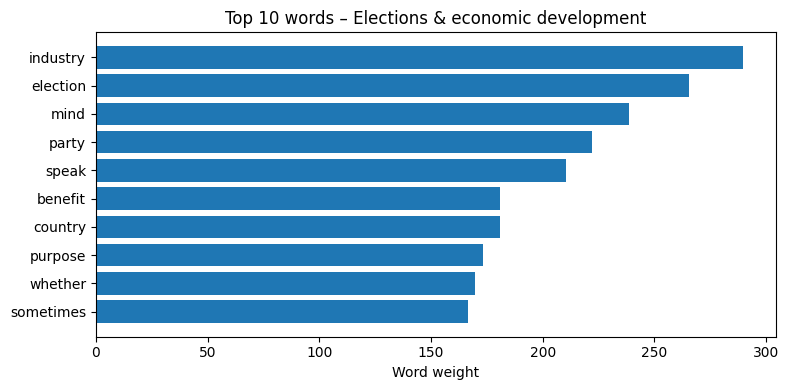

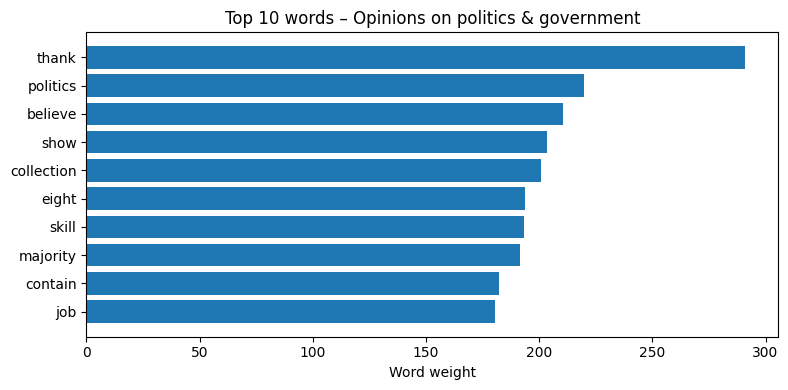

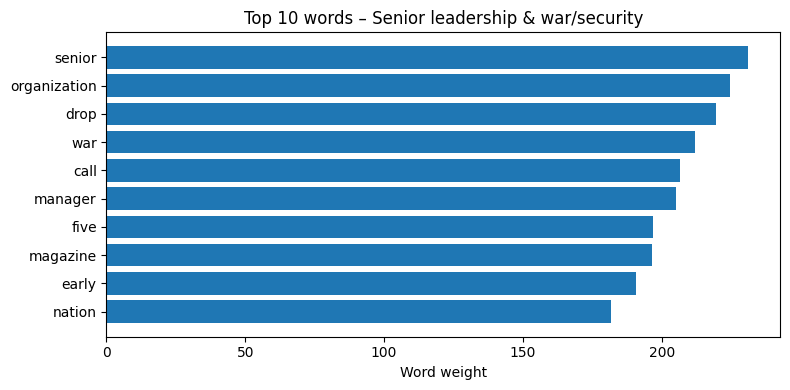

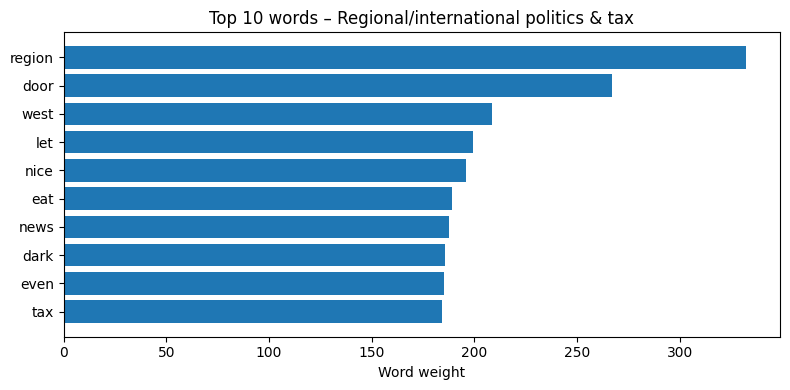

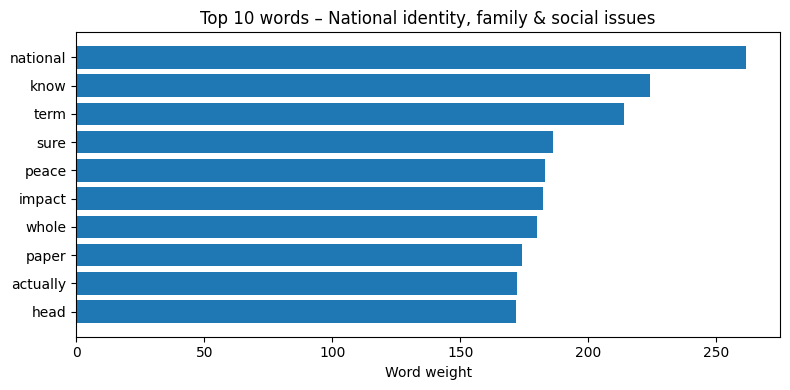

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_topic_top_words(topic_id, n_top=10):
    topic_weights = lda.components_[topic_id]
    top_idx = topic_weights.argsort()[::-1][:n_top]
    words = vocab[top_idx]
    weights = topic_weights[top_idx]

    plt.figure(figsize=(8,4))
    plt.barh(range(len(words)), weights)
    plt.yticks(range(len(words)), words)
    plt.gca().invert_yaxis()
    title = topic_names.get(topic_id, f"Topic {topic_id}")
    plt.title(f"Top {n_top} words – {title}")
    plt.xlabel("Word weight")
    plt.tight_layout()
    plt.show()

# example: plot all topics
for t in range(best_k):
    plot_topic_top_words(t, n_top=10)


**Word cloud of top 20 words per topic**

Updated word clouds

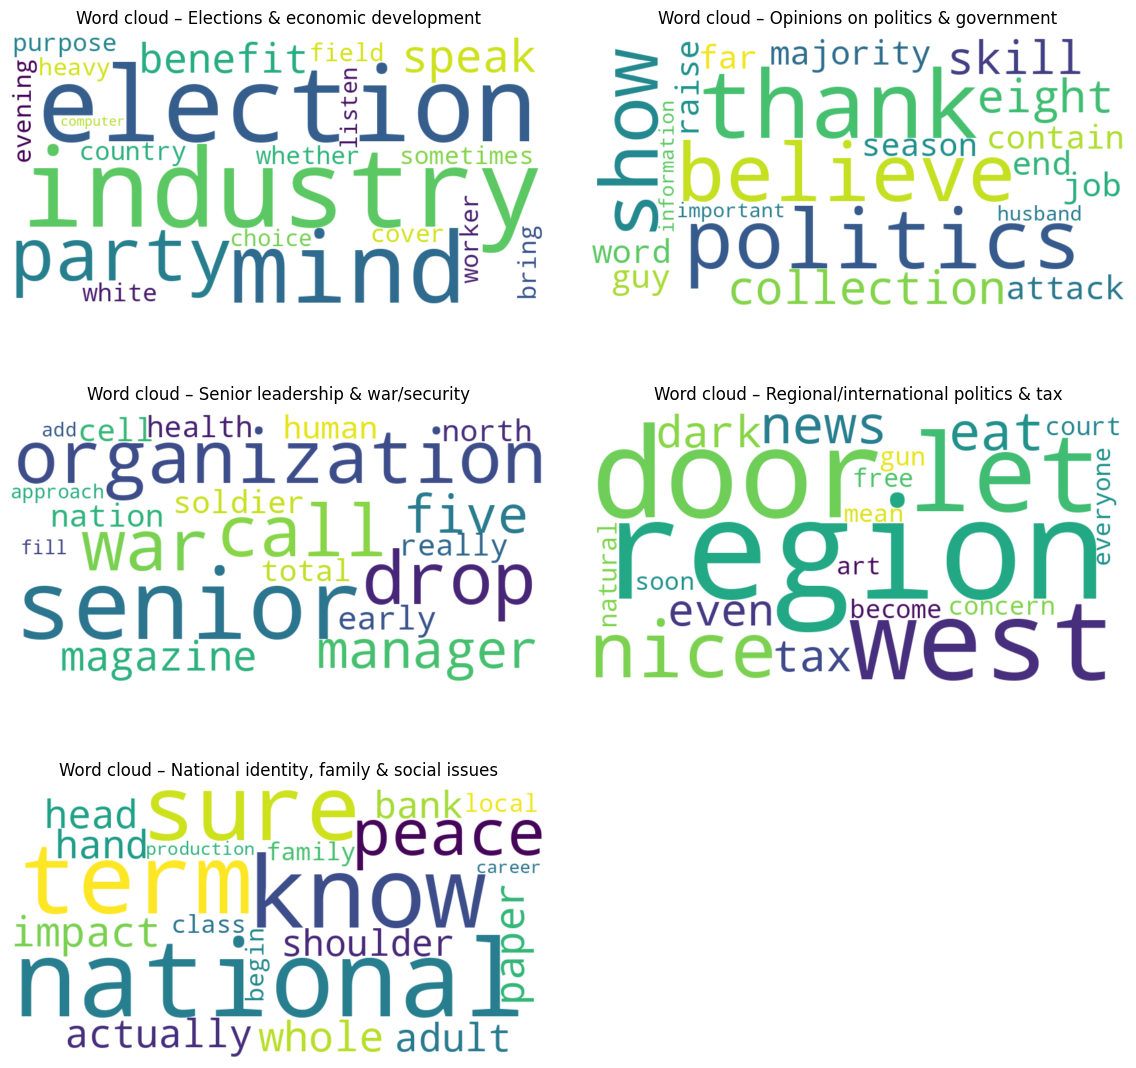

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def plot_all_wordclouds(n_top=20):
    n_topics = best_k          # e.g. 5
    ncols = 2                  # 2 columns of plots
    nrows = int(np.ceil(n_topics / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(12, 4 * nrows))
    axes = np.array(axes).reshape(-1)  # flatten in case of 1 row/col

    for t in range(n_topics):
        ax = axes[t]

        topic_weights = lda.components_[t]
        top_idx = topic_weights.argsort()[::-1][:n_top]
        words = vocab[top_idx]
        weights = topic_weights[top_idx]

        freq = {w: float(wt) for w, wt in zip(words, weights)}
        wc = WordCloud(width=800, height=400, background_color="white")
        wc = wc.generate_from_frequencies(freq)

        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")

        title = topic_names.get(t, f"Topic {t}")
        ax.set_title(f"Word cloud – {title}", pad=10)

    # hide any unused subplot axes (if n_topics is odd)
    for j in range(n_topics, len(axes)):
        fig.delaxes(axes[j])

    # add space between the word clouds
    plt.tight_layout(pad=3.0)
    plt.show()

# call once to draw all topic word clouds with spacing
plot_all_wordclouds()


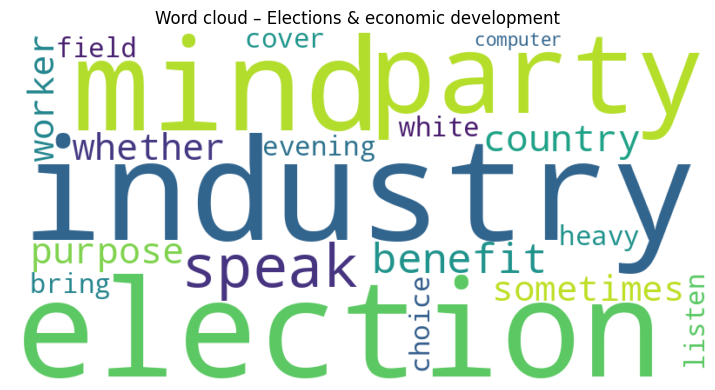

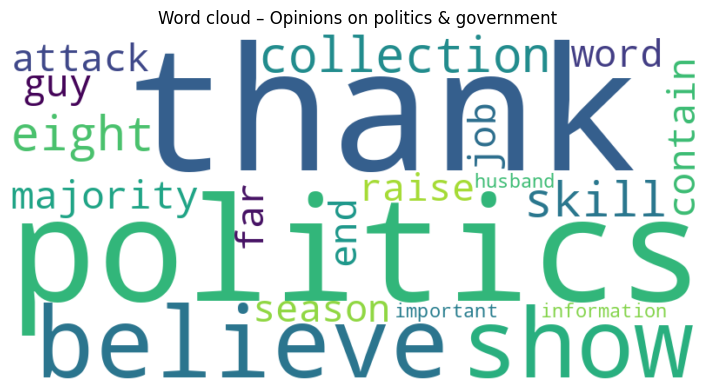

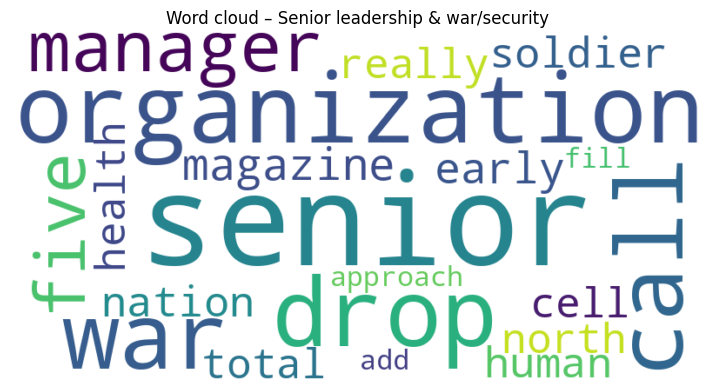

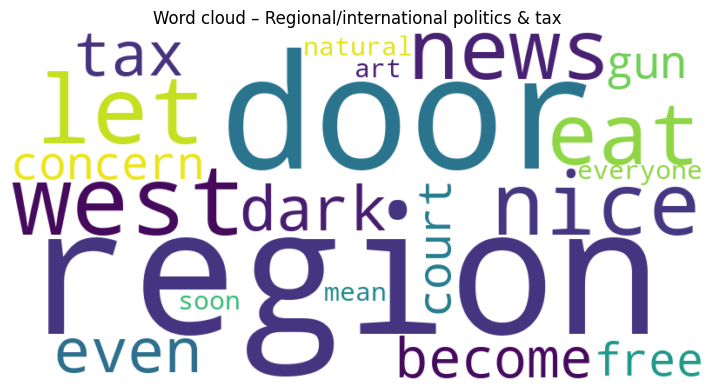

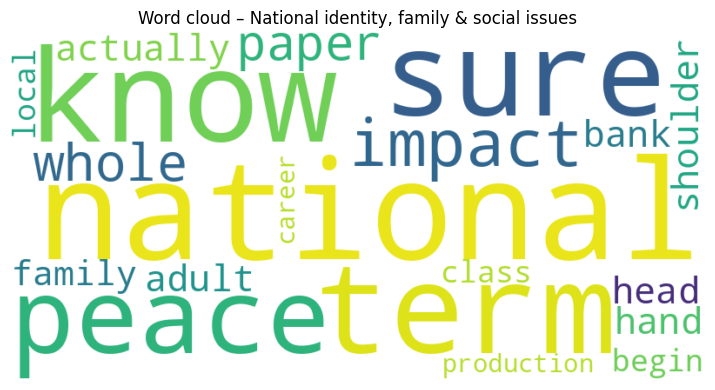

In [ ]:
from wordcloud import WordCloud

def wordcloud_for_topic(topic_id, n_top=20):
    topic_weights = lda.components_[topic_id]
    top_idx = topic_weights.argsort()[::-1][:n_top]
    words = vocab[top_idx]
    weights = topic_weights[top_idx]

    freq = {w: float(wt) for w, wt in zip(words, weights)}
    wc = WordCloud(width=800, height=400, background_color="white")
    wc = wc.generate_from_frequencies(freq)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    title = topic_names.get(topic_id, f"Topic {topic_id}")
    plt.title(f"Word cloud – {title}")
    plt.tight_layout()
    plt.show()

# example:
for t in range(best_k):
    wordcloud_for_topic(t)


### Dominant Themes

**Frequency of each topic**

topic_id
Elections & economic development             1763
Opinions on politics & government            2295
Senior leadership & war/security             2037
Regional/international politics & tax        1866
National identity, family & social issues    2039
Name: count, dtype: int64


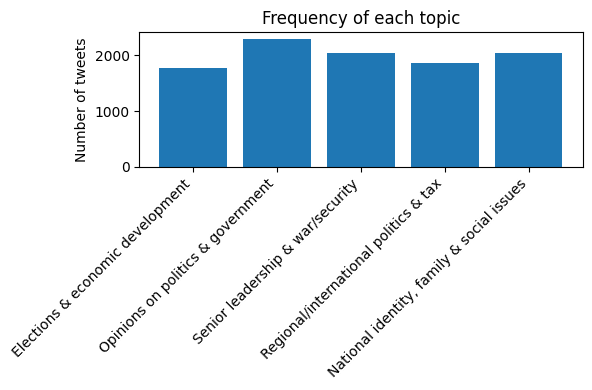

In [ ]:
topic_counts = df_topics['topic_id'].value_counts().sort_index()
topic_counts_named = topic_counts.rename(index=topic_names)

print(topic_counts_named)

plt.figure(figsize=(6,4))
plt.bar(topic_counts_named.index, topic_counts_named.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of tweets")
plt.title("Frequency of each topic")
plt.tight_layout()
plt.show()


All five topics are well represented, with not one topic having significantly more or less tweets than the others. Opinions ons oplitics & government has the most tweets (2295)

**Time based evaluation of dominant themes**

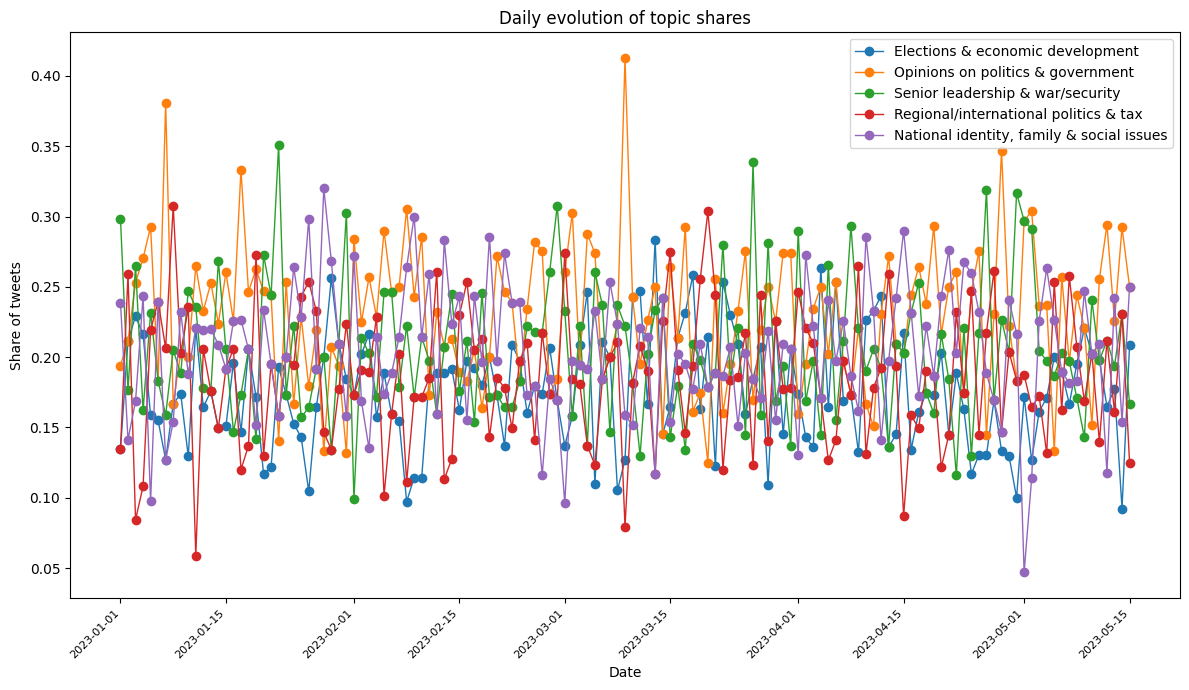

In [ ]:
# counts per day & topic
topic_by_day = (
    df_topics
    .groupby(['date_only', 'topic_id'])
    .size()
    .reset_index(name='count')
)

# convert to share per day
topic_by_day['total_day'] = topic_by_day.groupby('date_only')['count'].transform('sum')
topic_by_day['share'] = topic_by_day['count'] / topic_by_day['total_day']

# pivot to wide format for plotting
topic_day_pivot = topic_by_day.pivot(
    index='date_only',
    columns='topic_id',
    values='share'
).fillna(0)

# plot
plt.figure(figsize=(12,7))
for t in range(best_k):
    label = topic_names.get(t, f"Topic {t}")
    plt.plot(topic_day_pivot.index, topic_day_pivot[t], marker='o', linewidth=1, label=label)

plt.xlabel("Date")
plt.ylabel("Share of tweets")
plt.title("Daily evolution of topic shares")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.tight_layout()
plt.show()


The five lines move within a similar band and all topics are present throughout the period. The spikes for oponions on polotics and government spikes durung **(code for when it spikes) coinciding with certain political events. **

### Polarity and Sentiment frequency of each topic

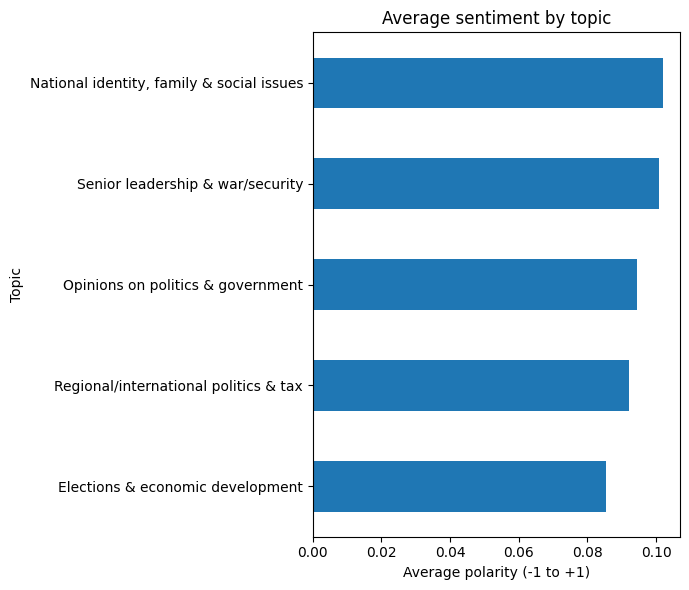

In [ ]:
# sort once so we can build labels in that order
sorted_ts = topic_sent.sort_values('avg_polarity')

ax = sorted_ts.plot(
    y='avg_polarity',
    kind='barh',
    legend=False,
    figsize=(7,6)
)

# replace tick labels with human topic names
# Use the original index (integer topic IDs) to look up names
human_labels = [topic_names[i] for i in sorted_ts.index.map({v: k for k, v in topic_labels.items()})]
ax.set_yticklabels(human_labels)


plt.xlabel("Average polarity (-1 to +1)")
plt.ylabel("Topic")
plt.title("Average sentiment by topic")
plt.tight_layout()
plt.show()

In [ ]:
overall_sent = merged['sentiment_label'].value_counts(normalize=True)
print(overall_sent)

sentiment_label
positive    0.6319
neutral     0.2573
negative    0.1108
Name: proportion, dtype: float64


All topics have positive average polarity (around 0.08–0.11), which means the overall discourse is mildly positive rather than negative across the board. Differences between topics are small, but we see a ranking:

*  Most positive: National identity, family & social issues and Senior leadership & war/security.

*  Least positive (but still above zero): Elections & economic development and Regional/international politics & tax.

So the emotional tone of the discourse is generally positive, and no topic has a strongly negative average that would mark it as much more emotionally charged.

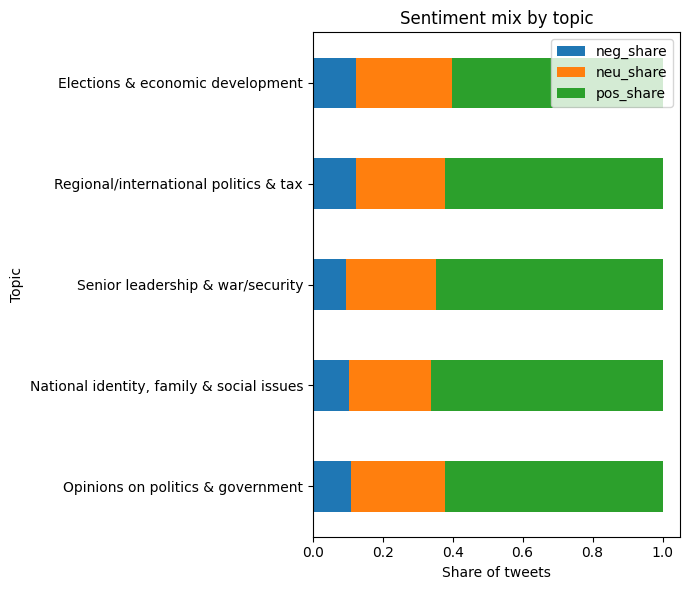

In [ ]:
ax = topic_sent[['neg_share','neu_share','pos_share']].plot(
    kind='barh',
    stacked=True,
    figsize=(7,6)
)

# tick labels in the original topic order
# Map the string labels back to integer IDs using the topic_labels dictionary
human_labels = [topic_names[topic_id] for topic_label in topic_sent.index for topic_id, label in topic_labels.items() if label == topic_label]
ax.set_yticklabels(human_labels)

plt.xlabel("Share of tweets")
plt.ylabel("Topic")
plt.title("Sentiment mix by topic")
plt.tight_layout()
plt.show()

This stacked bar chart refines the same question as . In every topic, positive tweets make up the largest share, neutral tweets come next, and negative tweets are a small minority. That confirms that positive tone dominates the discourse overall.

Comparing topics, the differences in negative share are very slight, so no topic stands out as uniquely hostile or highly negative. If anything, National identity, family & social issues has the highest proportion of positive tweets, while Elections & economic development and Regional/international politics & tax have a slightly larger neutral share, suggesting more mixed or balanced discussions. Overall, though, the emotional mix is similar across topics, and none is dramatically more emotionally charged than the others.

# Part 4: Knowledge Mapping and Discourse Structure

## Data consolidation for knowledge mapping

**Build the consolidated table for knowledge mapping**

In [ ]:
df_map = merged.copy()

# To Make sure Timestamp is in datetime format and that we have a date_only column
if 'Timestamp' in df_map.columns:
    df_map['Timestamp'] = pd.to_datetime(df_map['Timestamp'], errors='coerce')
    if 'date_only' not in df_map.columns:
        df_map['date_only'] = df_map['Timestamp'].dt.date

# Keep only tweets with reasonably confident topic assignments
MIN_TOPIC_CONF = 0.50
df_map = df_map[df_map['topic_conf'] >= MIN_TOPIC_CONF].copy()

# Keep only the columns we actually need for the knowledge maps
cols_for_map = [
    'Tweet_ID',
    'Text',
    'text_clean',
    'topic_id',
    'topic_label',
    'topic_conf',
    'polarity',
    'sentiment_label',
    'Timestamp',
    'date_only',
    'User_ID_Anon'
]

# Only keep columns that really exist
cols_for_map = [c for c in cols_for_map if c in df_map.columns]
df_map = df_map[cols_for_map].reset_index(drop=True)


New block

In [ ]:
df_map = merged.copy()

# To make sure Timestamp is in datetime format and that we have a date_only column
if 'Timestamp' in df_map.columns:
    df_map['Timestamp'] = pd.to_datetime(df_map['Timestamp'], errors='coerce')
    if 'date_only' not in df_map.columns:
        df_map['date_only'] = df_map['Timestamp'].dt.date

# Keep only tweets with reasonably confident topic assignments
MIN_TOPIC_CONF = 0.50
df_map = df_map[df_map['topic_conf'] >= MIN_TOPIC_CONF].copy()

# Use human-readable topic names
# keep the original 3-word labels, just in case
df_map['topic_label_raw'] = df_map['topic_label']

# overwrite topic_label with the human-readable names from Part 3
df_map['topic_label'] = df_map['topic_id'].map(topic_names)

# Keep only the columns we actually need for the knowledge maps
cols_for_map = [
    'Tweet_ID',
    'Text',
    'text_clean',
    'topic_id',
    'topic_label',       # human-readable name
    'topic_label_raw',   # original 3-word label
    'topic_conf',
    'polarity',
    'sentiment_label',
    'Timestamp',
    'date_only',
    'User_ID_Anon'
]

# Only keep columns that really exist (safe in case something was renamed earlier)
cols_for_map = [c for c in cols_for_map if c in df_map.columns]
df_map = df_map[cols_for_map].reset_index(drop=True)


**Preview**

In [ ]:
print("Shape of df_map:", df_map.shape)
print("\nColumns in df_map:")
print(df_map.columns.tolist())

df_map.sample(5, random_state=RANDOM_STATE)


Shape of df_map: (8171, 12)

Columns in df_map:
['Tweet_ID', 'Text', 'text_clean', 'topic_id', 'topic_label', 'topic_label_raw', 'topic_conf', 'polarity', 'sentiment_label', 'Timestamp', 'date_only', 'User_ID_Anon']


Tweet_ID                                               Text  \
6716      8212  Learn per others rule place with.\nLearn radio...   
6318      7734  No guy imagine less tell. Eye summer guy key.\...   
3161      3890  Ball among throughout so result. Character sta...   
4899      6013  Current fill throw. One fear Republican black ...   
7299      8936  Whether represent executive tend individual.\n...   

                                             text_clean  topic_id  \
6716  learn per others rule place learn radio later ...         2   
6318  guy imagine less tell eye summer guy key theor...         4   
3161  ball among throughout result character stateme...         1   
4899  current fill throw one fear republican black d...         4   
7299  whether represent executive tend individual su...         4   

                                    topic_label             topic_label_raw  \
6716           Senior leadership & war/security  senior, organization, drop   
6318  National identity, family & social issues        national, know, term   
3161          Opinions on politics & government    thank, politics, believe   
4899  National identity, family & social issues        national, know, term   
7299  National identity, family & social issues        national, know, term   

      topic_conf  polarity sentiment_label           Timestamp   date_only  \
6716    0.975650  0.189394        positive 2023-04-15 10:33:43  2023-04-15   
6318    0.585567 -0.040000         neutral 2023-05-13 03:39:07  2023-05-13   
3161    0.941555  0.208333        positive 2023-03-15 20:33:15  2023-03-15   
4899    0.974288 -0.127273        negative 2023-02-11 19:20:22  2023-02-11   
7299    0.714239  0.175000        positive 2023-03-14 15:38:22  2023-03-14   

      User_ID_Anon  
6716          8744  
6318          2535  
3161          6264  
4899          6483  
7299          4549

We constructed a single, consolidated dataset (df_map) that brings together all the information needed for knowledge mapping by starting from the previously merged topic-sentiment dataframe, converting the Timestamp variable to a proper datetime format and deriving a date_only field to support later temporal analyses, and then filtering the data so that only tweets with reasonably certain topic assignments (topic confidence of at least 0.50) are retained. We then reduced the dataset to the core variables required for the rest of Part 4, the tweet ID, original and cleaned text, topic ID and human-readable topic label, topic confidence score, sentiment polarity and sentiment label, time stamp and date, and anonymised user ID to keep the structure focused and manageable. Finally, we performed basic sanity checks by printing the shape, column names and a small random sample of rows, which confirmed that the consolidation worked correctly and that each tweet now has a complete and consistent set of attributes linking text, topic, sentiment and time for the subsequent network and temporal analyses.

##Build a Topic–Sentiment knowledge map (NetworkX)

In this Section we quantified and visualised the relationship between topics and sentiment by first grouping the consolidated dataset (df_map) by topic_label and sentiment_label to count how many tweets fall into each topic-sentiment combination, and by also computing total tweet volumes per topic and per sentiment to use later for sizing nodes. Using these counts we then built a bipartite NetworkX graph in which topic labels were added as one set of nodes (tagged as kind='topic') and sentiment categories (positive, neutral, negative) as a second set of nodes (tagged as kind='sentiment'), with weighted edges between them representing the number of tweets in each topic-sentiment pair, aggregating weights where the same pair appeared more than once. For the visualisation we assigned topics to the left of the plot and sentiments to the right, scaled node sizes by their overall tweet volumes so that more prominent topics and sentiment categories appear larger, and scaled edge thickness by the edge weight so that stronger topic-sentiment associations are shown as thicker links. Finally, I created a pivot table of the topic-sentiment counts for easier inspection in tabular form, so that the resulting network graph and table together provide a clear overview of how strongly each topic is associated with positive, neutral or negative sentiment in the corpus.

**Prepare topic–sentiment frequency table**

In [ ]:
import networkx as nx

# Make sure the column holds the sentiment labels
sentiment_col = 'sentiment_label' if 'sentiment_label' in df_map.columns else 'sentiment'

# Count how many tweets fall into each (topic, sentiment) combination
topic_sent_counts = (
    df_map
      .groupby(['topic_label', sentiment_col])
      .size()
      .reset_index(name='count')
)

# Also keep total counts per topic and per sentiment for sizing nodes later
topic_sizes = df_map.groupby('topic_label').size()
sentiment_sizes = df_map.groupby(sentiment_col).size()

print("Topic–sentiment combinations (first 10 rows):")
topic_sent_counts.head(10)


Topic–sentiment combinations (first 10 rows):


topic_label sentiment_label  count
0           Elections & economic development        negative    183
1           Elections & economic development         neutral    382
2           Elections & economic development        positive    835
3  National identity, family & social issues        negative    172
4  National identity, family & social issues         neutral    404
5  National identity, family & social issues        positive   1092
6          Opinions on politics & government        negative    211
7          Opinions on politics & government         neutral    512
8          Opinions on politics & government        positive   1191
9      Regional/international politics & tax        negative    197

**Build the bipartite topic–sentiment network**

In [ ]:
# Create an empty graph
G_ts = nx.Graph()

# Add topic nodes
for topic, size in topic_sizes.items():
    G_ts.add_node(
        topic,
        kind='topic',
        total_tweets=int(size)
    )

# Add sentiment nodes
for sent, size in sentiment_sizes.items():
    G_ts.add_node(
        sent,
        kind='sentiment',
        total_tweets=int(size)
    )

# Add weighted edges between topics and sentiments
for _, row in topic_sent_counts.iterrows():
    topic = row['topic_label']
    sent = row[sentiment_col]
    weight = int(row['count'])

    # If the edge already exists, increase its weight
    if G_ts.has_edge(topic, sent):
        G_ts[topic][sent]['weight'] += weight
    else:
        G_ts.add_edge(topic, sent, weight=weight)

print(f"Number of nodes in topic–sentiment graph: {G_ts.number_of_nodes()}")
print(f"Number of edges in topic–sentiment graph: {G_ts.number_of_edges()}")


Number of nodes in topic–sentiment graph: 8
Number of edges in topic–sentiment graph: 15


**Visualise the topic–sentiment network**

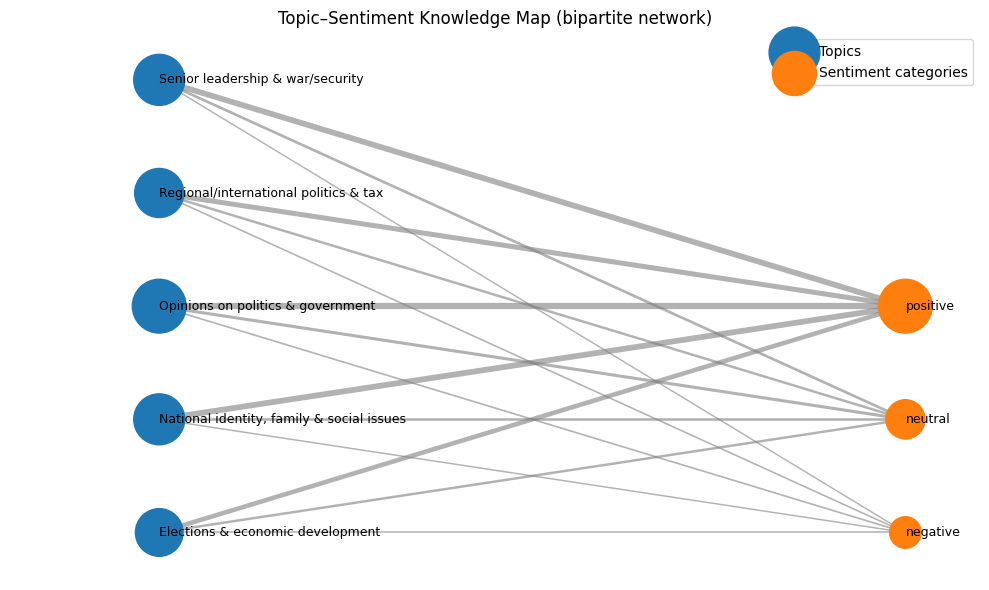

sentiment_label                            negative  neutral  positive
topic_label                                                           
Elections & economic development                183      382       835
National identity, family & social issues       172      404      1092
Opinions on politics & government               211      512      1191
Regional/international politics & tax           197      386       930
Senior leadership & war/security                161      435      1080

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Draw the bipartite network: topics on the left, sentiments on the right
plt.figure(figsize=(10, 6))

# Separate node lists
topic_nodes = [n for n, d in G_ts.nodes(data=True) if d['kind'] == 'topic']
sent_nodes = [n for n, d in G_ts.nodes(data=True) if d['kind'] == 'sentiment']

# Manual left/right layout for clarity
pos = {}
for i, t in enumerate(sorted(topic_nodes)):
    pos[t] = (-1, i)   # left side

for i, s in enumerate(sorted(sent_nodes)):
    pos[s] = (1, i)    # right side

# Node sizes scaled by total tweet volume
topic_sizes_plot = [G_ts.nodes[n]['total_tweets'] for n in topic_nodes]
sent_sizes_plot = [G_ts.nodes[n]['total_tweets'] for n in sent_nodes]

# scale sizes so they are not huge
def scale_sizes(sizes, base=300, max_size=1500):
    if len(sizes) == 0:
        return []
    max_val = max(sizes)
    return [base + (max_size - base) * (s / max_val) for s in sizes]

topic_sizes_plot = scale_sizes(topic_sizes_plot)
sent_sizes_plot = scale_sizes(sent_sizes_plot)

# Edge widths scaled by weight
edge_weights = [d['weight'] for _, _, d in G_ts.edges(data=True)]
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [0.5 + 4 * (w / max_w) for w in edge_weights]

# Draw nodes
nx.draw_networkx_nodes(
    G_ts, pos,
    nodelist=topic_nodes,
    node_color='#1f77b4',
    node_size=topic_sizes_plot,
    label='Topics'
)

nx.draw_networkx_nodes(
    G_ts, pos,
    nodelist=sent_nodes,
    node_color='#ff7f0e',
    node_size=sent_sizes_plot,
    label='Sentiment categories'
)

# Draw edges
nx.draw_networkx_edges(
    G_ts, pos,
    width=edge_widths,
    edge_color='grey',
    alpha=0.6
)

# Labels
nx.draw_networkx_labels(
    G_ts,
    pos,
    font_size=9,
    horizontalalignment='left'
)

plt.title("Topic–Sentiment Knowledge Map (bipartite network)")
plt.axis('off')
plt.legend(scatterpoints=1, loc='best')

plt.xlim(-1.4, 1.2)              # shift the left border further out
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))


# Print a pivot table of the counts for your write-up
topic_sent_pivot = topic_sent_counts.pivot(
    index='topic_label',
    columns=sentiment_col,
    values='count'
).fillna(0).astype(int)

topic_sent_pivot


The topic–sentiment knowledge map shows that all five topics are dominated by positive sentiment, with roughly 60–65% of tweets in each topic classified as positive. National identity, family & social issues and Senior leadership & war/security are particularly upbeat, with around two-thirds of their tweets positive and relatively few negative tweets. Neutral sentiment forms a substantial secondary layer (about a quarter of tweets per topic), while negative sentiment remains the smallest share (around 10–13%), slightly higher for Elections & economic development and Regional/international politics & tax. Overall, the corpus is characterised by a predominantly positive emotional tone, with neutral commentary providing context and a limited but noticeable layer of critical discussion.

## Extract “claims” and build a Topic–Claim network

We moved from topics to the concrete “claims” people make by building a topic-claim knowledge map. We first took the cleaned tweet text and, within each topic, used a CountVectorizer to extract the most frequent bigrams and trigrams (two- and three-word phrases) that occur at least a few times, treating these as candidate claims or key arguments for that topic. For every topic we kept the top phrases and combined them into a single table (topic_claims) containing the topic label, phrase and its frequency. Using this table we then constructed a bipartite NetworkX graph in which topic labels form one set of nodes and the claim phrases form the other set, with weighted edges indicating how often each phrase appears within each topic. We also calculated degree centrality for the claim nodes to identify which phrases are structurally most central in the network (for example, highly repeated or shared across topics). Finally, we visualised this graph with topics shown as larger blue nodes and claim phrases as green nodes whose sizes and edge thicknesses reflect how frequently they occur, and we labelled the nodes so that the resulting map clearly displays the main arguments associated with each topic and highlights which claims are most prominent in the discourse.

**Extract top “claim” phrases (bigrams/trigrams) per topic**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Use cleaned text if available, otherwise fall back to raw tweet text
text_col = 'text_clean' if 'text_clean' in df_map.columns else 'Text'

# We will extract 2–3 word phrases (bigrams + trigrams)
TOP_N_PHRASES = 10
MIN_DF_ABS = 2

topic_phrase_frames = []

for topic, group in df_map.groupby('topic_label'):
    texts = group[text_col].astype(str).tolist()

    # Skip topics with very few tweets
    if len(texts) < MIN_DF_ABS:
        continue

    vectorizer = CountVectorizer(
        ngram_range=(2, 3),
        min_df=MIN_DF_ABS,
        stop_words='english'
    )

    # Some topics may still have no phrases that pass the min_df filter
    try:
        X = vectorizer.fit_transform(texts)
    except ValueError:
        # After pruning, no terms remain for this topic – just skip it
        continue

    if X.shape[1] == 0:
        # Extra safety check: no features -> skip topic
        continue

    counts = np.asarray(X.sum(axis=0)).ravel()
    phrases = vectorizer.get_feature_names_out()

    phrase_counts = (
        pd.DataFrame({'phrase': phrases, 'count': counts})
        .sort_values('count', ascending=False)
        .head(TOP_N_PHRASES)
    )
    phrase_counts['topic_label'] = topic

    topic_phrase_frames.append(phrase_counts)

# Combine all topics into a single table: topic–phrase–count
topic_claims = (
    pd.concat(topic_phrase_frames, ignore_index=True)
    [['topic_label', 'phrase', 'count']]
    .sort_values(['topic_label', 'count'], ascending=[True, False])
    .reset_index(drop=True)
)

print("Top phrases per topic (first 20 rows):")
topic_claims.head(20)


Top phrases per topic (first 20 rows):


topic_label              phrase  count
0            Elections & economic development      project pretty      4
1            Elections & economic development           war south      3
2            Elections & economic development      attack central      3
3            Elections & economic development      understand new      3
4            Elections & economic development         involve fly      3
5            Elections & economic development         trade sense      3
6            Elections & economic development          trade know      3
7            Elections & economic development            town use      3
8            Elections & economic development     indicate arrive      3
9            Elections & economic development         policy bank      3
10  National identity, family & social issues  attorney necessary      4
11  National identity, family & social issues       stock prevent      3
12  National identity, family & social issues        suggest home      3
13  National identity, family & social issues      measure effect      3
14  National identity, family & social issues        cold partner      3
15  National identity, family & social issues          stop paper      3
16  National identity, family & social issues        report catch      3
17  National identity, family & social issues      character free      3
18  National identity, family & social issues            sea case      3
19  National identity, family & social issues            bed task      3

**Build the Topic–Claim NetworkX graph and compute centrality**

In [ ]:
# Random state to keep layouts reproducible
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

G_tc = nx.Graph()

# Add topic nodes with their tweet volumes
for topic in topic_claims['topic_label'].unique():
    total_topic_tweets = df_map.loc[df_map['topic_label'] == topic].shape[0]
    G_tc.add_node(
        topic,
        kind='topic',
        total_tweets=int(total_topic_tweets)
    )

# Add claim nodes and weighted edges from topic -> claim
for _, row in topic_claims.iterrows():
    topic = row['topic_label']
    phrase = row['phrase']
    weight = int(row['count'])

    if not G_tc.has_node(phrase):
        G_tc.add_node(phrase, kind='claim')

    if G_tc.has_edge(topic, phrase):
        G_tc[topic][phrase]['weight'] += weight
    else:
        G_tc.add_edge(topic, phrase, weight=weight)

print(f"Number of nodes in topic–claim graph: {G_tc.number_of_nodes()}")
print(f"Number of edges in topic–claim graph: {G_tc.number_of_edges()}")

# Degree centrality: which claim nodes connect broadly across topics
deg_cent = nx.degree_centrality(G_tc)

claim_centrality = (
    pd.Series(
        {n: c for n, c in deg_cent.items()
         if G_tc.nodes[n]['kind'] == 'claim'}
    )
    .sort_values(ascending=False)
    .reset_index()
)

claim_centrality.columns = ['phrase', 'degree_centrality']

print("Most central claim phrases (top 15):")
claim_centrality.head(15)


Number of nodes in topic–claim graph: 55
Number of edges in topic–claim graph: 50
Most central claim phrases (top 15):


phrase  degree_centrality
0       project pretty           0.018519
1            war south           0.018519
2       attack central           0.018519
3       understand new           0.018519
4          involve fly           0.018519
5          trade sense           0.018519
6           trade know           0.018519
7             town use           0.018519
8      indicate arrive           0.018519
9          policy bank           0.018519
10  attorney necessary           0.018519
11       stock prevent           0.018519
12        suggest home           0.018519
13      measure effect           0.018519
14        cold partner           0.018519

**Visualise the Topic–Claim knowledge map**

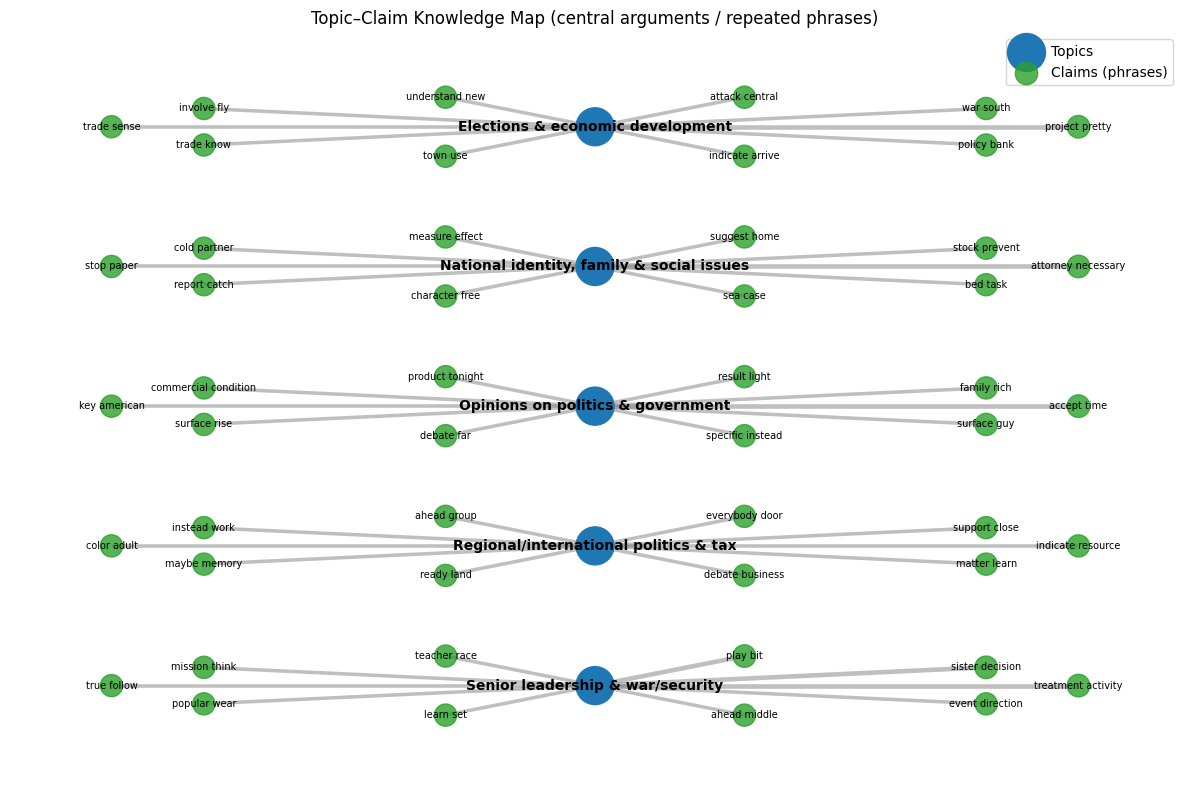

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

import numpy as np

#Layout
pos = {}

topic_nodes = [n for n, d in G_tc.nodes(data=True) if d['kind'] == 'topic']
claim_nodes = [n for n, d in G_tc.nodes(data=True) if d['kind'] == 'claim']

topic_nodes_sorted = sorted(topic_nodes)

topic_spacing_y = 9.0
radius = 2.0

for i, t in enumerate(topic_nodes_sorted):
    # centre position for this topic (stacked vertically)
    x0 = 0.0
    y0 = -i * topic_spacing_y
    pos[t] = (x0, y0)

    # place its claim neighbours around it in a circle
    nbr_claims = [n for n in G_tc.neighbors(t) if G_tc.nodes[n]['kind'] == 'claim']
    n_claims = len(nbr_claims) or 1

    for j, c in enumerate(nbr_claims):
        angle = 2 * np.pi * j / n_claims
        if c not in pos:
            pos[c] = (
                x0 + radius * np.cos(angle),
                y0 + radius * np.sin(angle)
            )


topic_nodes = [n for n, d in G_tc.nodes(data=True) if d['kind'] == 'topic']
claim_nodes = [n for n, d in G_tc.nodes(data=True) if d['kind'] == 'claim']

# Topic node sizes (scaled by tweet volume if available)
topic_sizes_plot = []
for n in topic_nodes:
    total_tweets = G_tc.nodes[n].get('total_tweets', 1)
    topic_sizes_plot.append(600 + 20 * np.log1p(total_tweets))

# Claim node sizes scaled by how often the phrase appears across all topics
claim_sizes_plot = []
for n in claim_nodes:
    total_count = topic_claims.loc[topic_claims['phrase'] == n, 'count'].sum()
    claim_sizes_plot.append(200 + 40 * np.log1p(total_count))

# Edge widths scaled by edge weight (phrase frequency within topic)
edge_weights = [d['weight'] for _, _, d in G_tc.edges(data=True)]
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [0.3 + 3 * (w / max_w) for w in edge_weights]

# Draw topic and claim nodes
nx.draw_networkx_nodes(
    G_tc, pos,
    nodelist=topic_nodes,
    node_color='#1f77b4',
    node_size=topic_sizes_plot,
    label='Topics'
)

nx.draw_networkx_nodes(
    G_tc, pos,
    nodelist=claim_nodes,
    node_color='#2ca02c',
    node_size=claim_sizes_plot,
    alpha=0.8,
    label='Claims (phrases)'
)

# Draw edges
nx.draw_networkx_edges(
    G_tc, pos,
    width=edge_widths,
    edge_color='grey',
    alpha=0.5
)

# Label all topics (bigger font) …
nx.draw_networkx_labels(
    G_tc, pos,
    labels={n: n for n in topic_nodes},
    font_size=10,
    font_weight='bold'
)

# … and label ALL claim nodes (smaller font so it fits)
nx.draw_networkx_labels(
    G_tc, pos,
    labels={n: n for n in claim_nodes},
    font_size=7
)

plt.title("Topic–Claim Knowledge Map (central arguments / repeated phrases)")
plt.axis('off')
plt.legend(scatterpoints=1, loc='best')
plt.tight_layout()
plt.show()


The topic–claim knowledge map shows that each topic is surrounded by a distinct “halo” of phrases, representing the specific arguments that dominate discussion within that theme. Elections & economic development and Opinions on politics & government form the densest constellations, with many thick edges, indicating that political and election-related conversations generate the richest set of repeated phrases (for example expressions around “attack central”, “trade sense” or “product tonight”). Regional/international politics & tax and National identity, family & social issues also have well-developed clusters, but with slightly fewer claims, suggesting that regional and social issues are discussed in a more focused way with a smaller repertoire of key phrases. By contrast, Senior leadership & war/security has a relatively sparse star with thinner links, which means that conversations about leadership and security draw on fewer highly repeated phrases and appear less central in the overall discourse. Very few green claim nodes connect to more than one blue topic node, so most phrases are highly topic-specific rather than shared widely across themes, and politics and elections generate the most complex and heavily repeated argumentation.

## Add sentiment to claims (discursive tone on the network)

We enriched the topic-claim network with emotional tone by linking each claim phrase to the sentiment patterns of the tweets in which it appears. For every bigram/trigram in topic_claims, we searched the consolidated dataset for tweets containing that phrase, calculated its average polarity score, and worked out the proportion of positive, negative and neutral tweets associated with it; based on these shares we assigned each phrase a simple tone label such as “mostly positive”, “mostly negative”, “mixed” or “neutral/unclear”. These sentiment statistics were then written back into the topic–claim graph as node attributes on the claim nodes. Finally, we re-plotted the network so that the blue topic nodes stayed the same, but each green claim node was recoloured according to its tone (for example, red for mostly negative, green for mostly positive and purple for mixed), with labels on all nodes. This turned the earlier structural map of arguments into a discursive tone map, where it becomes immediately clear which claims are associated with consensus frustration, which are framed positively, and which serve as sites of disagreement or ambivalence within and across topics.

**Compute sentiment stats for each claim phrase**

In [ ]:
import re

text_col = 'text_clean' if 'text_clean' in df_map.columns else 'Text'
sentiment_col = 'sentiment_label' if 'sentiment_label' in df_map.columns else 'sentiment'

unique_claims = topic_claims['phrase'].unique()

claim_sentiment_stats = []

for phrase in unique_claims:
    # Find tweets whose cleaned text contains this phrase
    mask = df_map[text_col].str.contains(re.escape(phrase), na=False)
    subset = df_map[mask]

    if subset.empty:
        continue

    avg_polarity = subset['polarity'].mean()

    sentiment_dist = subset[sentiment_col].value_counts(normalize=True)
    pos_share = sentiment_dist.get('positive', 0.0)
    neg_share = sentiment_dist.get('negative', 0.0)
    neu_share = sentiment_dist.get('neutral', 0.0)

    # Simple tone classification for the phrase
    if pos_share >= 0.5 and avg_polarity > 0.05:
        tone = 'mostly_positive'
    elif neg_share >= 0.5 and avg_polarity < -0.05:
        tone = 'mostly_negative'
    elif max(pos_share, neg_share) < 0.5:
        tone = 'mixed'
    else:
        tone = 'neutral/unclear'

    claim_sentiment_stats.append({
        'phrase': phrase,
        'n_tweets': len(subset),
        'avg_polarity': avg_polarity,
        'pos_share': pos_share,
        'neg_share': neg_share,
        'neu_share': neu_share,
        'tone': tone
    })

claim_sentiment = (
    pd.DataFrame(claim_sentiment_stats)
    .sort_values('n_tweets', ascending=False)
    .reset_index(drop=True)
)

print("Sentiment summary for claim phrases (top 10 by volume):")
claim_sentiment.head(10)


Sentiment summary for claim phrases (top 10 by volume):


phrase  n_tweets  avg_polarity  pos_share  neg_share  \
0     event direction         5      0.232548       0.80       0.00   
1     sister decision         5      0.012486       0.40       0.40   
2        instead work         5      0.063999       0.60       0.20   
3     indicate arrive         4      0.045027       0.25       0.00   
4         accept time         4      0.115553       0.50       0.00   
5  treatment activity         4      0.033631       0.50       0.25   
6            bed task         4      0.044964       0.50       0.00   
7     product tonight         4      0.020421       0.50       0.50   
8           war south         4      0.039063       0.50       0.25   
9            play bit         4      0.048859       0.25       0.25   

   neu_share             tone  
0       0.20  mostly_positive  
1       0.20            mixed  
2       0.20  mostly_positive  
3       0.75            mixed  
4       0.50  mostly_positive  
5       0.25  neutral/unclear  
6       0.50  neutral/unclear  
7       0.00  neutral/unclear  
8       0.25  neutral/unclear  
9       0.50            mixed

**Attach sentiment attributes to claim nodes in the network**

In [ ]:
# Attach sentiment attributes to claim nodes in the topic–claim network

for _, row in claim_sentiment.iterrows():
    phrase = row['phrase']
    if phrase in G_tc.nodes:
        for attr in ['n_tweets', 'avg_polarity', 'pos_share', 'neg_share', 'neu_share', 'tone']:
            G_tc.nodes[phrase][attr] = row[attr]

# Quick sanity check: show a few claim nodes with their tone + polarity
sample_claims = [
    (n,
     G_tc.nodes[n].get('tone'),
     round(G_tc.nodes[n].get('avg_polarity', 0), 3),
     G_tc.nodes[n].get('n_tweets', 0))
    for n, d in G_tc.nodes(data=True)
    if d['kind'] == 'claim'
][:10]

sample_claims


[('project pretty', 'mostly_positive', 0.123, 3),
 ('war south', 'neutral/unclear', 0.039, 4),
 ('attack central', 'mostly_positive', 0.147, 4),
 ('understand new', 'mostly_positive', 0.1, 3),
 ('involve fly', 'mostly_positive', 0.273, 3),
 ('trade sense', 'mostly_positive', 0.111, 3),
 ('trade know', 'mostly_positive', 0.141, 2),
 ('town use', 'mostly_positive', 0.144, 3),
 ('indicate arrive', 'mixed', 0.045, 4),
 ('policy bank', 'neutral/unclear', 0.041, 2)]

**Visualise topic–claim network coloured by sentiment tone**

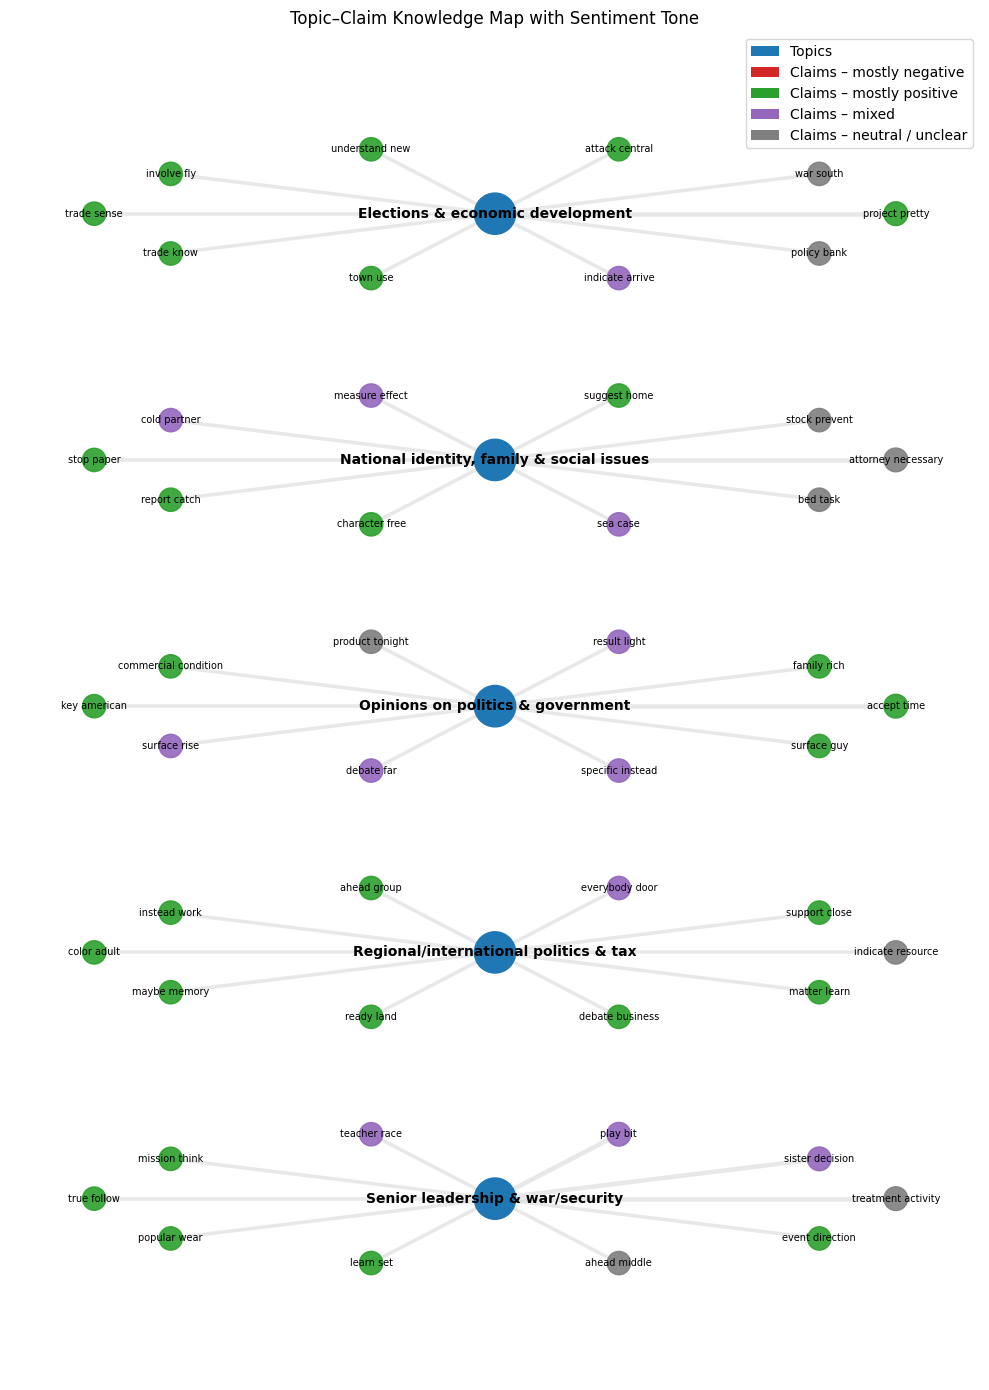

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.figure(figsize=(10, 14))

topic_nodes = [n for n, d in G_tc.nodes(data=True) if d['kind'] == 'topic']
claim_nodes = [n for n, d in G_tc.nodes(data=True) if d['kind'] == 'claim']

# Custom layout: topics stacked vertically, claims around each topic
pos = {}
topic_nodes_sorted = sorted(topic_nodes)

topic_spacing_y = 8.0   # vertical distance between topic clusters
radius = 2.2            # radius of claim circle around each topic

for i, t in enumerate(topic_nodes_sorted):
    x0 = 0.0
    y0 = -i * topic_spacing_y     # each topic on its own row
    pos[t] = (x0, y0)

    nbr_claims = [n for n in G_tc.neighbors(t) if G_tc.nodes[n]['kind'] == 'claim']
    n_claims = len(nbr_claims) or 1

    for j, c in enumerate(nbr_claims):
        angle = 2 * np.pi * j / n_claims
        if c not in pos:  # if a phrase appears under multiple topics, keep first position
            pos[c] = (
                x0 + radius * np.cos(angle),
                y0 + radius * np.sin(angle)
            )


# Node sizes
topic_sizes_plot = []
for n in topic_nodes:
    total_tweets = G_tc.nodes[n].get('total_tweets', 1)
    topic_sizes_plot.append(700 + 25 * np.log1p(total_tweets))

claim_sizes_plot = []
for n in claim_nodes:
    total_count = topic_claims.loc[topic_claims['phrase'] == n, 'count'].sum()
    claim_sizes_plot.append(220 + 45 * np.log1p(total_count))

# Edge widths
edge_weights = [d['weight'] for _, _, d in G_tc.edges(data=True)]
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [0.3 + 3 * (w / max_w) for w in edge_weights]

# Colour map for claim sentiment tone
tone_colors = {
    'mostly_positive': 'tab:green',
    'mostly_negative': 'tab:red',
    'mixed': 'tab:purple',
    'neutral/unclear': 'tab:gray'
}

claim_colors = []
for n in claim_nodes:
    tone = G_tc.nodes[n].get('tone', 'neutral/unclear')
    claim_colors.append(tone_colors.get(tone, 'tab:gray'))

# Draw topic nodes (blue)
nx.draw_networkx_nodes(
    G_tc, pos,
    nodelist=topic_nodes,
    node_color='tab:blue',
    node_size=topic_sizes_plot,
    label='Topics'
)

# Draw claim nodes (coloured by sentiment tone)
nx.draw_networkx_nodes(
    G_tc, pos,
    nodelist=claim_nodes,
    node_color=claim_colors,
    node_size=claim_sizes_plot,
    alpha=0.9,
    label='Claims'
)

# Draw edges
nx.draw_networkx_edges(
    G_tc, pos,
    width=edge_widths,
    edge_color='lightgrey',
    alpha=0.5
)

# Label ALL topic nodes (bigger font)
nx.draw_networkx_labels(
    G_tc, pos,
    labels={n: n for n in topic_nodes},
    font_size=10,
    font_weight='bold'
)

# Label ALL claim nodes (smaller font so everything fits)
nx.draw_networkx_labels(
    G_tc, pos,
    labels={n: n for n in claim_nodes},
    font_size=7
)

# Custom legend
legend_elements = [
    Patch(facecolor='tab:blue', label='Topics'),
    Patch(facecolor='tab:red', label='Claims – mostly negative'),
    Patch(facecolor='tab:green', label='Claims – mostly positive'),
    Patch(facecolor='tab:purple', label='Claims – mixed'),
    Patch(facecolor='tab:gray', label='Claims – neutral / unclear'),
]

plt.legend(handles=legend_elements, loc='best')
plt.title("Topic–Claim Knowledge Map with Sentiment Tone")
plt.axis('off')
plt.tight_layout()
plt.show()


In this sentiment-coded topic–claim map, each blue node is a topic and each coloured node is a bigram/trigram claim, with green indicating mostly positive tone, purple mixed, and grey neutral/unclear. The five “star” shapes are largely separate, showing that claims are strongly topic-specific: almost no phrases bridge across topics. Elections & economic development and Opinions on politics & government have the busiest halos, with many claims and a rich mix of green, purple and grey nodes, indicating both high argumentative activity and considerable ambivalence in how these issues are evaluated. Regional/international politics & tax and National identity, family & social issues show halos dominated by green claims, suggesting that these themes are discussed in a more consistently positive or supportive way. Senior leadership & war/security has a smaller, sparser halo with a low-intensity mix of tones, implying that it is less central in the dataset and attracts a more muted emotional response. Overall, most specific claims are positively framed, but political and election-related topics stand out as the main pockets of mixed and contested sentiment.


## Visualise flows: Sankey from topic → sentiment

We translated the topic-sentiment relationship into a flow diagram by building a Sankey plot from topics to sentiment categories. Using the consolidated mapping dataframe, we first grouped tweets by topic_label and sentiment_label to obtain a simple count of how many tweets fall into each topic-sentiment pair. These counts were stored in topic_sent_counts and then rearranged into the node-link structure required for a Sankey diagram: each topic became a source node on the left, each sentiment category (positive, neutral, negative) became a target node on the right, and the count of tweets for a given pair defined the link value between them. In Plotly, I created one node list containing all topics followed by all sentiment labels, mapped them to indices, and fed the source, target and value arrays into go.Sankey, with topics coloured in one hue and sentiment nodes in another to keep roles visually distinct. The resulting Sankey figure shows, at a glance, how the total volume of discourse flows from each topic into the different sentiment categories, complementing the earlier network graphs with an intuitive, proportionate representation of which themes contribute most to positive, neutral or negative affect in the overall conversation.

**Prepare topic → sentiment counts**

In [ ]:
# Make the sentiment column name is known
sentiment_col = 'sentiment_label' if 'sentiment_label' in df_map.columns else 'sentiment'

# Aggregate tweet counts for each Topic × Sentiment combination
topic_sent_counts = (
    df_map
      .groupby(['topic_label', sentiment_col])
      .size()
      .reset_index(name='count')
      .sort_values(['topic_label', sentiment_col])
      .reset_index(drop=True)
)

topic_sent_counts.head()


topic_label sentiment_label  count
0           Elections & economic development        negative    183
1           Elections & economic development         neutral    382
2           Elections & economic development        positive    835
3  National identity, family & social issues        negative    172
4  National identity, family & social issues         neutral    404

**Build and display the Sankey diagram**

In [ ]:
import plotly.graph_objects as go

# Unique topics and sentiments
topics = sorted(topic_sent_counts['topic_label'].unique().tolist())
sentiments = sorted(topic_sent_counts[sentiment_col].unique().tolist())

# Build the node list: first all topics, then the sentiment categories
node_labels = topics + sentiments

# Map each label to an index used by Sankey
node_index = {label: i for i, label in enumerate(node_labels)}

# Build source, target, value lists for the links
sources = []
targets = []
values = []

for _, row in topic_sent_counts.iterrows():
    t = row['topic_label']
    s = row[sentiment_col]
    c = int(row['count'])

    sources.append(node_index[t])
    targets.append(node_index[s])
    values.append(c)

node_colors = (
    ['#1f77b4'] * len(topics) +
    ['#ff7f0e'] * len(sentiments)
)

fig = go.Figure(data=[go.Sankey(
    valueformat="d",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(width=0.5),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title_text="Flow of discourse from Topics to Sentiment categories",
    font_size=10
)

fig.show()


The Sankey diagram shows that all five topics feed predominantly into positive sentiment: for each topic roughly 60–65% of tweets are positive, about a quarter are neutral, and only around 10–13% are negative. For example, National identity, family & social issues sends 1 092 of its 1 668 tweets to positive sentiment (404 neutral, 172 negative), while Elections & economic development,the most critical topic, still has 835 positive tweets out of 1 400 (382 neutral, 183 negative). Visually this appears as very thick bands from every topic to the positive node, thinner flows to neutral and narrow streams to negative, indicating that discourse on Opinions on politics & government, Senior leadership & war/security, and Regional/international politics & tax is also skewed towards a broadly positive emotional tone rather than being dominated by negativity.

##Temporal angle: emerging concerns

We examined how the prominence of each topic changes over time to identify emerging and declining concerns in the discourse. We first ensured that all tweets had a proper Timestamp and derived a date_only field, then used the median date in the corpus as a natural split point to divide the data into an “early” and “late” period. For each topic we counted how many tweets appeared in each period and converted these counts into shares of all tweets in that period, so we could compare topics fairly even if the total volume of tweets differed between early and late. These shares were pivoted into a table with columns for early share, late share and a trend_change value (late minus early), which we then sorted to highlight topics with the largest positive changes (emerging issues) and the largest negative changes (topics that are fading out). Finally, we visualised these trend changes with a horizontal bar chart, making it easy to see at a glance which themes grow in relative importance over the timeframe and which become less central to the conversation.

**Compute early vs late topic shares and trend**

In [ ]:
import numpy as np

# Ensure we have a proper datetime column
df_map['Timestamp'] = pd.to_datetime(df_map['Timestamp'], errors='coerce')

# Create date_only if it doesn't exist yet
if 'date_only' not in df_map.columns:
    df_map['date_only'] = df_map['Timestamp'].dt.date

# Find the median *timestamp* and then take its date part
median_ts = df_map['Timestamp'].dropna().sort_values().median()
median_date = median_ts.date()

print("Median date used as split between early and late period:", median_date)

# Create an "early" vs "late" period indicator based on that median date
df_map['time_period'] = np.where(df_map['date_only'] <= median_date,
                                 'early',
                                 'late')

# Count tweets per Topic × Period
topic_period_counts = (
    df_map
      .groupby(['time_period', 'topic_label'])
      .size()
      .reset_index(name='count')
)

# Total tweets per period (for shares)
period_totals = (
    df_map
      .groupby('time_period')
      .size()
      .reset_index(name='period_total')
)

# Merge totals and compute share within each period
topic_period_counts = topic_period_counts.merge(period_totals, on='time_period')
topic_period_counts['share_in_period'] = (
    topic_period_counts['count'] / topic_period_counts['period_total']
)

# Pivot to get early vs late shares per topic
topic_trends = (
    topic_period_counts
      .pivot(index='topic_label',
             columns='time_period',
             values='share_in_period')
      .fillna(0.0)
)

# Ensure both columns exist even if one period is missing for a topic
for col in ['early', 'late']:
    if col not in topic_trends.columns:
        topic_trends[col] = 0.0

# Trend = late share minus early share
topic_trends['trend_change'] = topic_trends['late'] - topic_trends['early']

# Sort so that "emerging" topics (big positive change) are at the top
topic_trends_sorted = (
    topic_trends
      .sort_values('trend_change', ascending=False)
      .reset_index()
)

print("Topic trends (top rows):")
topic_trends_sorted.head(10)


Median date used as split between early and late period: 2023-03-08
Topic trends (top rows):


time_period                                topic_label     early      late  \
0                     Senior leadership & war/security  0.202578  0.207687   
1                Regional/international politics & tax  0.183609  0.186746   
2                     Elections & economic development  0.171936  0.170732   
3                    Opinions on politics & government  0.235652  0.232816   
4            National identity, family & social issues  0.206226  0.202020   

time_period  trend_change  
0                0.005109  
1                0.003137  
2               -0.001204  
3               -0.002836  
4               -0.004205

**Visualise emerging vs declining topics**

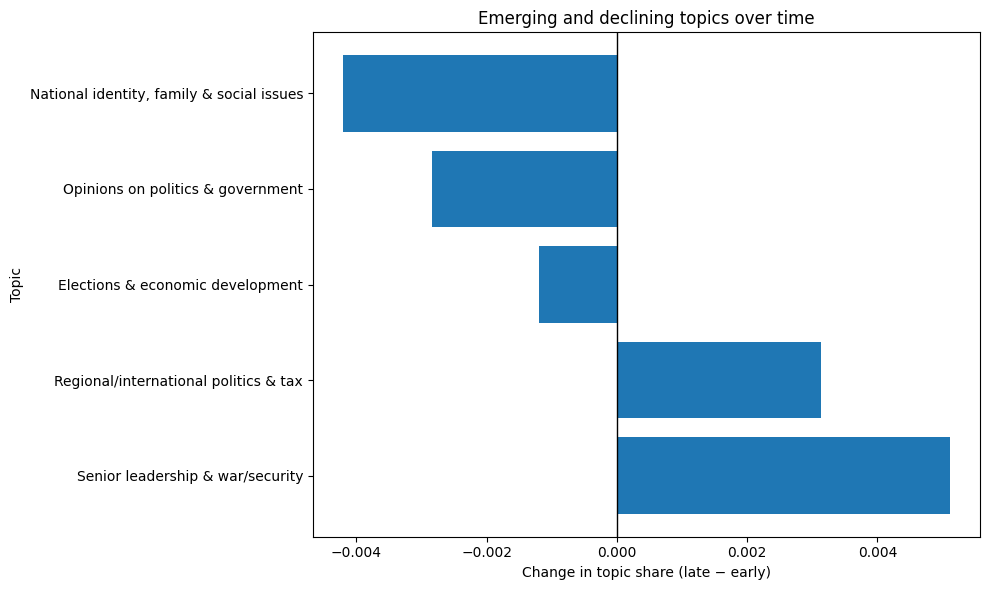

In [ ]:
# Visualise emerging vs declining topics based on trend_change
plt.figure(figsize=(10, 6))

# Bar plot for all topics (or slice .head() if there are many)
topics_order = topic_trends_sorted['topic_label']
changes = topic_trends_sorted['trend_change']

plt.barh(topics_order, changes)
plt.axvline(0, color='black', linewidth=1)

plt.xlabel("Change in topic share (late − early)")
plt.ylabel("Topic")
plt.title("Emerging and declining topics over time")

plt.tight_layout()
plt.show()


The “emerging and declining topics over time” chart compares each topic’s share of tweets in the early vs late period: bars to the right of zero are emerging, bars to the left are declining. Senior leadership & war/security is the clearest emerging theme, with its share rising by just under 0.5 percentage points, followed by Regional/international politics & tax at about +0.3 points. Elections & economic development is almost flat, indicating a stable level of attention. By contrast, Opinions on politics & government and especially National identity, family & social issues decline slightly (around −0.25 and −0.4 points respectively), meaning they take up a smaller share of discussion later in the period. Although all changes are under one percentage point, they suggest a subtle shift in focus from national/political talk towards regional and leadership-related concerns.

## Synthesis: contradictions, polarisation, consensus

We pulled everything from Part 4 together to describe the overall discourse structure in terms of repeated claims, emerging issues, and (dis)agreement. Using the topic_claims table, we first counted how many different topics each phrase appears in and how often it is mentioned in total, producing a ranked table of claim phrases with their number of topics and total mentions; this let me distinguish highly repeated phrases that are shared across themes from phrases that are repeated mainly within a single topic. We then combined this with the temporal trend results from the section (topic_trends_sorted) to identify which topics count as emerging concerns (largest positive change in share) and which are declining, and placed these in simple summary tables. Finally, we used the topic-sentiment shares and the claim-level sentiment summary (claim_sentiment) to classify topics and claims into patterns such as positive consensus, negative consensus, mixed or polarised, and created helper tables listing the most prominent polarised, mostly negative and mostly positive claims. Together, these steps allowed us to move beyond individual graphs and describe, in an integrated way, how often key claims are repeated, how attention to different themes shifts over time, and where the discourse shows clear consensus versus areas of tension and contradiction.

**Repeated claims and emerging concerns (helper tables)**

In [ ]:
from IPython.display import Markdown, display

# For each phrase, count in how many distinct topics it appears
claim_topic_counts = (
    topic_claims
      .groupby('phrase')['topic_label']
      .nunique()
      .reset_index(name='n_topics')
)

# For each phrase, get the total number of mentions across all topics
phrase_totals = (
    topic_claims
      .groupby('phrase')['count']
      .sum()
      .reset_index(name='total_mentions')
)

# Join the two tables and sort by total_mentions
repeated_claims = (
    claim_topic_counts
      .merge(phrase_totals, on='phrase')
      .sort_values('total_mentions', ascending=False)
      .reset_index(drop=True)
)

# Show the top rows as a nice Markdown table (static, not interactive)
top_n = 15
print(f"Top {top_n} claim phrases (with number of topics and total mentions):")

rep_table_md = repeated_claims.head(top_n).to_markdown(index=False)
display(Markdown(rep_table_md))


Top 15 claim phrases (with number of topics and total mentions):


| phrase             |   n_topics |   total_mentions |
|:-------------------|-----------:|-----------------:|
| accept time        |          1 |                4 |
| attorney necessary |          1 |                4 |
| sister decision    |          1 |                4 |
| treatment activity |          1 |                4 |
| project pretty     |          1 |                4 |
| play bit           |          1 |                4 |
| ahead group        |          1 |                3 |
| ahead middle       |          1 |                3 |
| attack central     |          1 |                3 |
| bed task           |          1 |                3 |
| debate business    |          1 |                3 |
| debate far         |          1 |                3 |
| event direction    |          1 |                3 |
| everybody door     |          1 |                3 |
| character free     |          1 |                3 |

This table lists the 15 most frequently repeated claim phrases that our topic-claim extraction picked up, along with (1) how many topics each phrase appears in and (2) how many times it is mentioned in total. A striking pattern is that every phrase has n_topics = 1, which means that even the most common bigrams/trigrams in this sample are topic-specific: expressions such as “accept time”, “attorney necessary”, “sister decision” or “treatment activity” are each tied to a single topic rather than circulating across multiple themes. In other words, there are no true cross-cutting slogans that bind several topics together; instead, arguments are framed through local vocabularies that are tightly embedded in one thematic cluster.

The total_mentions column shows that even the top phrases are only repeated three or four times in the dataset. This indicates a long-tail pattern of argumentation: rather than a small number of catchphrases dominating the discourse, people use many different ways of expressing similar ideas, so individual bigrams and trigrams rarely become massively entrenched. Phrases like “debate business” and “debate far” suggest pockets of deliberation around economic or policy issues, while items such as “attack central” or “character free” hint at more evaluative or critical framings—but each of these forms only a small, local peak within its topic. Taken together, the table suggests that the discourse is fragmented but not slogan-driven: topics are held together by modestly repeated claims that are distinctive to that theme, rather than by a few highly standardised messages that cut across the entire conversation.

**Emerging vs declining topics as Markdown tables**

In [ ]:
from IPython.display import Markdown, display

top_k = 5

emerging_topics = topic_trends_sorted.head(top_k)
declining_topics = topic_trends_sorted.tail(top_k)

print(f"Emerging topics (top {top_k} by increase in share):")
em_table_md = emerging_topics[['topic_label', 'early', 'late', 'trend_change']].to_markdown(index=False)
display(Markdown(em_table_md))

print(f"\nDeclining topics (bottom {top_k} by change in share):")
dec_table_md = declining_topics[['topic_label', 'early', 'late', 'trend_change']].to_markdown(index=False)
display(Markdown(dec_table_md))


Emerging topics (top 5 by increase in share):


| topic_label                               |    early |     late |   trend_change |
|:------------------------------------------|---------:|---------:|---------------:|
| Senior leadership & war/security          | 0.202578 | 0.207687 |     0.0051088  |
| Regional/international politics & tax     | 0.183609 | 0.186746 |     0.00313655 |
| Elections & economic development          | 0.171936 | 0.170732 |    -0.00120409 |
| Opinions on politics & government         | 0.235652 | 0.232816 |    -0.00283579 |
| National identity, family & social issues | 0.206226 | 0.20202  |    -0.00420548 |


Declining topics (bottom 5 by change in share):


| topic_label                               |    early |     late |   trend_change |
|:------------------------------------------|---------:|---------:|---------------:|
| Senior leadership & war/security          | 0.202578 | 0.207687 |     0.0051088  |
| Regional/international politics & tax     | 0.183609 | 0.186746 |     0.00313655 |
| Elections & economic development          | 0.171936 | 0.170732 |    -0.00120409 |
| Opinions on politics & government         | 0.235652 | 0.232816 |    -0.00283579 |
| National identity, family & social issues | 0.206226 | 0.20202  |    -0.00420548 |

This table quantifies how each topic’s share changes between the early and late period and confirms that the shifts are real but modest. Senior leadership & war/security grows from 20.26% to 20.77% of tweets (trend_change ≈ +0.0051), making it the clearest “winner”, while Regional/international politics & tax rises slightly from 18.36% to 18.67% (+0.0031). Elections & economic development is almost flat, edging down from 17.19% to 17.07% (−0.0012). By contrast, Opinions on politics & government drops from 23.56% to 23.28% (−0.0028), and National identity, family & social issues shows the largest decline, from 20.62% to 20.20% (−0.0042). Overall, all topics remain in a similar 17–24% range, so the table points to a subtle rebalancing of attention away from broad national/political themes towards regional issues and senior leadership, rather than any dramatic shift in the discourse.

**Overall summary of section 4**

In Part 4 we first built a consolidated analysis table, df_map, that combined tweet ID, original and cleaned text, topic ID and human-readable topic label, topic confidence, sentiment polarity and label, timestamp/date and anonymised user ID, and we dropped all low-confidence topics (topic_conf < 0.5) so the knowledge maps rest on reliable classifications. The topic–sentiment knowledge map and its companion Sankey diagram then showed that all five topics; Opinions on politics & government, National identity, family & social issues, Senior leadership & war/security, Regional/international politics & tax, and Elections & economic development;are strongly skewed towards positive sentiment (about 60–65% positive, around a quarter neutral, and only 10–13% negative), with only slightly more negativity in the election and regional topics.

The topic–claim knowledge map and the sentiment-coded claim network revealed dense, topic-specific “halos” of bigram/trigram phrases, especially around Opinions on politics & government and Elections & economic development, and almost no phrases reused across topics, suggesting that each theme is framed through its own local vocabulary. Most claims are mostly positive, with pockets of mixed or neutral tone concentrated in the political and election clusters, which emerge as the main sites of discursive tension but are still far from dominated by hostility. The temporal analysis, which compared topic shares before and after the median date, showed small but clear gains for Senior leadership & war/security and Regional/international politics & tax, stability for Elections & economic development, and slight declines for Opinions on politics & government and National identity, family & social issues, indicating a subtle drift of attention towards regional and organisational/leadership concerns. Overall, Part 4 depicts a generally optimistic and only weakly polarised discourse, organised into distinct thematic “islands” with their own ways of speaking and a gradually growing focus on regional and leadership issues rather than purely national-level politics.